# **Visualizations of Experimental Results**

In [ ]:
import re
import json
import math
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

# **Utils**

In [ ]:
def load_json(path):
    with open(path, 'r') as f:
        return json.load(f)


def load_histories(run_dir):
    all_histories = {}
    for p in Path(run_dir).iterdir():
        if not p.is_dir():
            continue

        history_path = p / "history.json"
        if not history_path.exists():
            continue

        all_histories[p.name] = load_json(history_path)

    return all_histories


def load_results(run_dir):
    all_results = {}
    for p in Path(run_dir).iterdir():
        if not p.is_dir():
            continue

        results_path = p / "results.json"
        if not results_path.exists():
            continue

        all_results[p.name] = load_json(results_path)
    
    return all_results


def extract_param(run_name: str, key: str) -> float:
    """
    Extract numeric sweep parameters such as lambda_init and lambda_lr
    from names like: 'sweep_lambda_init=1.05__lambda_lr=0.1'
    """
    m = re.search(rf"{key}=([0-9.]+)", run_name)
    if not m:
        raise ValueError(f"Could not find {key} in run name: {run_name}")
    return float(m.group(1))


def plot_global(all_histories):
    # group runs by lambda_init
    groups = defaultdict(list)
    lr_values = set()

    for run_name, history in all_histories.items():
        lam_init = extract_param(run_name, "lambda_init")
        lam_lr   = extract_param(run_name, "lambda_lr")
        lr_values.add(lam_lr)
        groups[lam_init].append((run_name, lam_lr, history))

    lambda_inits = sorted(groups.keys())
    lr_values = sorted(lr_values)

    cmap = plt.get_cmap("tab10")
    lr_to_color = {lr: cmap(i % 10) for i, lr in enumerate(lr_values)}

    fig, axs = plt.subplots(1, len(lambda_inits), figsize=(16, 4), dpi=150, sharey=True)
    if len(lambda_inits) == 1:
        axs = [axs]

    fig.suptitle("λ over Epochs Grouped by λ_init", fontsize=16, weight="bold")
    for ax, lam_init in zip(axs, lambda_inits):
        for run_name, lam_lr, history in groups[lam_init]:
            epochs = range(len(history["lambda"]))
            color = lr_to_color[lam_lr]
            label = f"λ_lr={lam_lr}"

            ax.plot(epochs, history["lambda"], lw=1.8, label=label, color=color)

        ax.set_title(f"λ (λ_init = {lam_init})")
        ax.set_xlabel("Epoch", fontsize=13)
        ax.set_ylabel("λ", fontsize=13)
        ax.title.set_fontsize(13)
        ax.tick_params(axis='both', which='major', labelsize=11)
        ax.tick_params(axis='both', which='minor', labelsize=9)
        ax.grid(True, which="both", linestyle="--", alpha=0.6)
        ax.minorticks_on()

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=len(labels), fontsize=13, frameon=False)
    fig.tight_layout(rect=[0, 0.08, 1, 0.95])  # extra bottom space for legend
    plt.show()

    # Validation loss over epochs
    fig, axs = plt.subplots(1, len(lambda_inits), figsize=(16, 4), dpi=150, sharey=True)
    if len(lambda_inits) == 1:
        axs = [axs]

    fig.suptitle("Validation Loss over Epochs Grouped by λ_init", fontsize=16, weight="bold")

    for ax, lam_init in zip(axs, lambda_inits):
        for run_name, lam_lr, history in groups[lam_init]:
            if "val_loss" not in history:
                continue

            epochs = range(len(history["val_loss"]))
            color = lr_to_color[lam_lr]
            label = f"λ_lr={lam_lr}"

            ax.plot(epochs, history["val_loss"], lw=1.8, label=label, color=color)

        ax.set_title(f"Validation Loss (λ_init = {lam_init})")
        ax.set_xlabel("Epoch", fontsize=13)
        ax.set_ylabel("Val Loss", fontsize=13)
        ax.title.set_fontsize(13)
        ax.tick_params(axis='both', which='major', labelsize=11)
        ax.tick_params(axis='both', which='minor', labelsize=9)
        ax.grid(True, which="both", linestyle="--", alpha=0.6)
        ax.minorticks_on()

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=len(labels), fontsize=13, frameon=False)
    fig.tight_layout(rect=[0, 0.08, 1, 0.95])
    plt.show()


def plot_multi(all_histories):
    groups = defaultdict(list)
    lr_values = set()

    for run_name, history in all_histories.items():
        lam_init = extract_param(run_name, "lambda_init")
        lam_lr   = extract_param(run_name, "lambda_lr")

        lr_values.add(lam_lr)
        groups[lam_init].append((run_name, lam_lr, history))

    lambda_inits = sorted(groups.keys())
    lr_values = sorted(lr_values)

    cmap = plt.get_cmap("tab10")
    lr_to_color = {lr: cmap(i % 10) for i, lr in enumerate(lr_values)}

    fig, axs = plt.subplots(1, len(lambda_inits), figsize=(6 * len(lambda_inits), 4), dpi=150, sharey=True)
    if len(lambda_inits) == 1:
        axs = [axs]

    fig.suptitle("Mean λ over Epochs Grouped by λ_init", fontsize=16, weight="bold")

    for ax, lam_init in zip(axs, lambda_inits):
        for run_name, lam_lr, history in groups[lam_init]:
            if "lambda_mean" in history:
                lambda_mean = history["lambda_mean"]
            else:
                lambda_keys = [k for k in history.keys() if re.match(r"lambda_\d+$", k)]
                if not lambda_keys:
                    continue
                lambda_array = np.array([history[k] for k in sorted(lambda_keys)])
                lambda_mean = lambda_array.mean(axis=0)

            epochs = range(len(lambda_mean))
            color = lr_to_color[lam_lr]
            label = f"λ_lr={lam_lr}"

            ax.plot(epochs, lambda_mean, lw=1.8, label=label, color=color)

        ax.set_title(f"Mean λ over Epochs (λ_init = {lam_init})")
        ax.set_xlabel("Epoch", fontsize=13)
        ax.set_ylabel("Mean λ", fontsize=13)
        ax.title.set_fontsize(13)
        ax.tick_params(axis='both', which='major', labelsize=11)
        ax.tick_params(axis='both', which='minor', labelsize=9)
        ax.grid(True, which="both", linestyle="--", alpha=0.6)
        ax.minorticks_on()

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=len(labels), fontsize=13, frameon=False)

    fig.tight_layout(rect=[0, 0.08, 1, 0.95])  # leave space for legend
    plt.show()

    fig, axs = plt.subplots(1, len(lambda_inits), figsize=(16, 4), dpi=150, sharey=True)
    if len(lambda_inits) == 1:
        axs = [axs]

    fig.suptitle("Validation Loss over Epochs Grouped by λ_init", fontsize=16, weight="bold")

    for ax, lam_init in zip(axs, lambda_inits):
        for run_name, lam_lr, history in groups[lam_init]:
            if "val_loss" not in history:
                continue

            epochs = range(len(history["val_loss"]))
            color = lr_to_color[lam_lr]
            label = f"λ_lr={lam_lr}"

            ax.plot(epochs, history["val_loss"], lw=1.8, label=label, color=color)

        ax.set_title(f"Validation Loss (λ_init = {lam_init})")
        ax.set_xlabel("Epoch", fontsize=13)
        ax.set_ylabel("Val Loss", fontsize=13)
        ax.title.set_fontsize(13)
        ax.tick_params(axis='both', which='major', labelsize=11)
        ax.tick_params(axis='both', which='minor', labelsize=9)
        ax.grid(True, which="both", linestyle="--", alpha=0.6)
        ax.minorticks_on()

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=len(labels), fontsize=13, frameon=False)
    fig.tight_layout(rect=[0, 0.08, 1, 0.95])
    plt.show()


def plot_individual_lambdas(all_histories):
    all_histories = dict(sorted(all_histories.items(), key=lambda x: x[0]))
    
    # Collect all lambda_* keys that exist in any run
    all_lambda_keys = set()
    for history in all_histories.values():
        for k in history.keys():
            if k.startswith("lambda_") and k[len("lambda_"):].isdigit():
                all_lambda_keys.add(k)

    lambda_keys = sorted(
        all_lambda_keys,
        key=lambda k: int(k.split("_")[1])
    )

    cmap = plt.cm.tab20
    lambda_colors = {
        k: cmap(i % cmap.N) for i, k in enumerate(lambda_keys)
    }

    n = len(all_histories)
    rows = cols = math.ceil(math.sqrt(n))
    fig, axs = plt.subplots(rows, cols, figsize=(22, 22), dpi=150)
    axs = axs.flatten()

    fig.suptitle("Individual Lambda Values", fontsize=22, weight="bold")

    for i, (run_name, history) in enumerate(all_histories.items()):
        ax = axs[i]

        first_lambda_key = next(k for k in lambda_keys if k in history)
        epochs = range(len(history[first_lambda_key]))

        for k in lambda_keys:
            if k in history:
                ax.plot(
                    epochs,
                    history[k],
                    lw=2,
                    color=lambda_colors[k],
                )

        lam_init = extract_param(run_name, "lambda_init")
        lam_lr   = extract_param(run_name, "lambda_lr")

        if lam_init is not None and lam_lr is not None:
            title = f"λ_init={lam_init}, λ_lr={lam_lr}"
        else:
            title = run_name

        ax.set_title(title, fontsize=16)
        ax.set_xlabel("Epoch", fontsize=14)
        ax.set_ylabel("Lambda Value", fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.tick_params(axis='both', which='minor', labelsize=12 - 1)
        ax.grid(True, linestyle="--", alpha=0.7, linewidth=1.0)

    for j in range(i + 1, rows * cols):
        fig.delaxes(axs[j])

    # Shared legend for lambda_0, lambda_1, ...
    handles = [
        plt.Line2D([0], [0], color=lambda_colors[k], lw=2, label=k)
        for k in lambda_keys
    ]
    ncol_legend = min(len(handles), 6)
    fig.legend(handles=handles, loc="lower center", ncol=ncol_legend, fontsize=14, frameon=False)

    fig.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()


# **Churn**

## **Hessian Damping**

## **Global-λ**

[0.0, 0.5, 0.9]


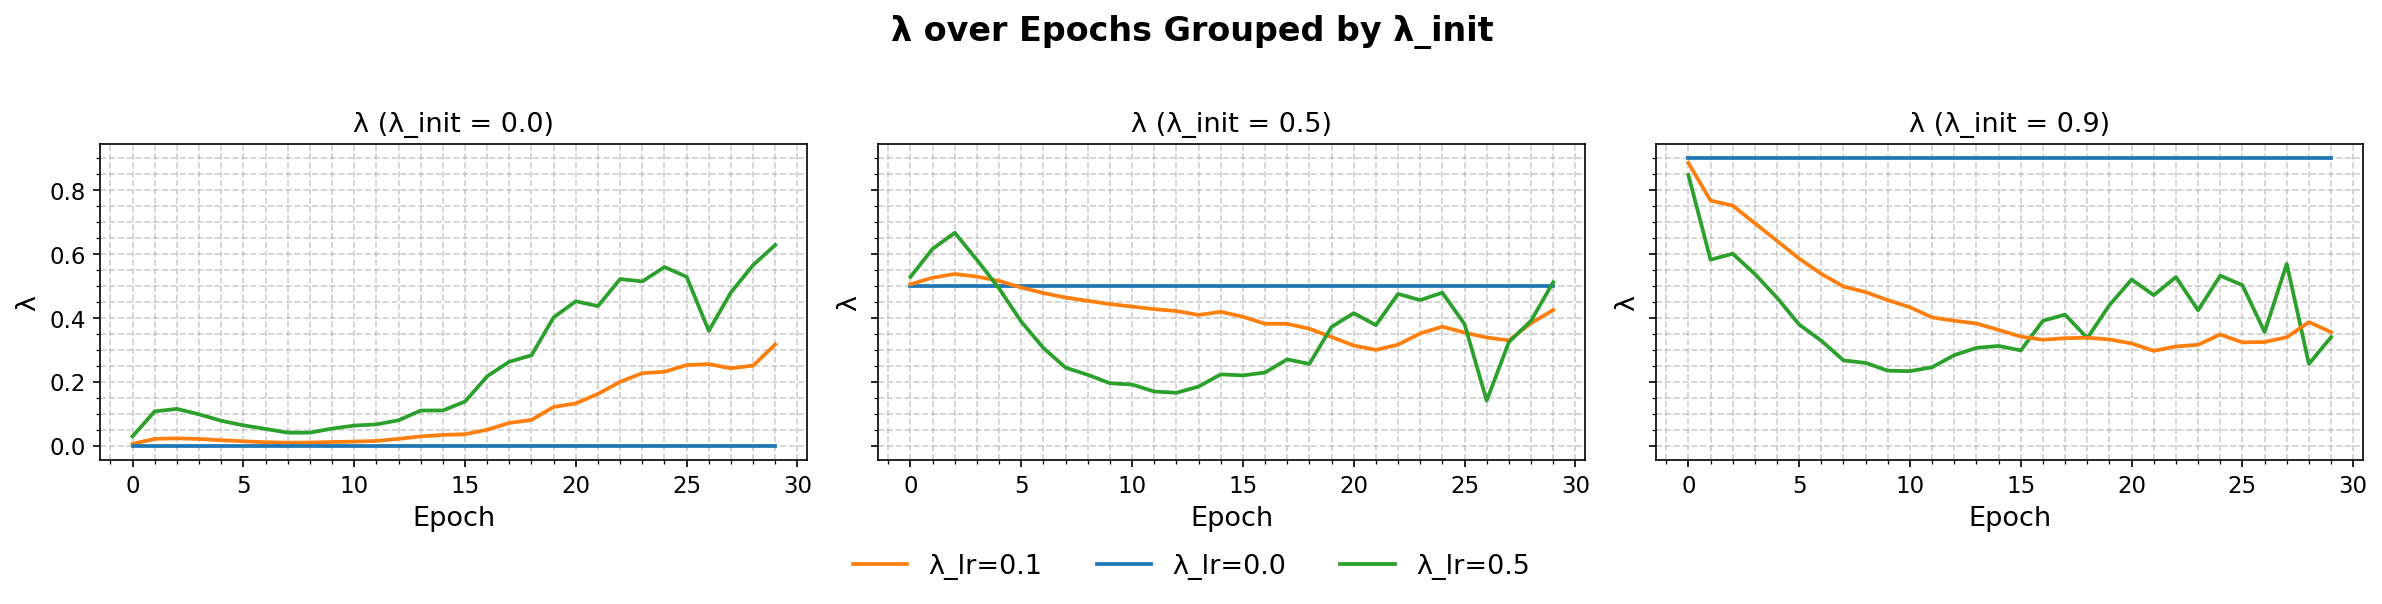

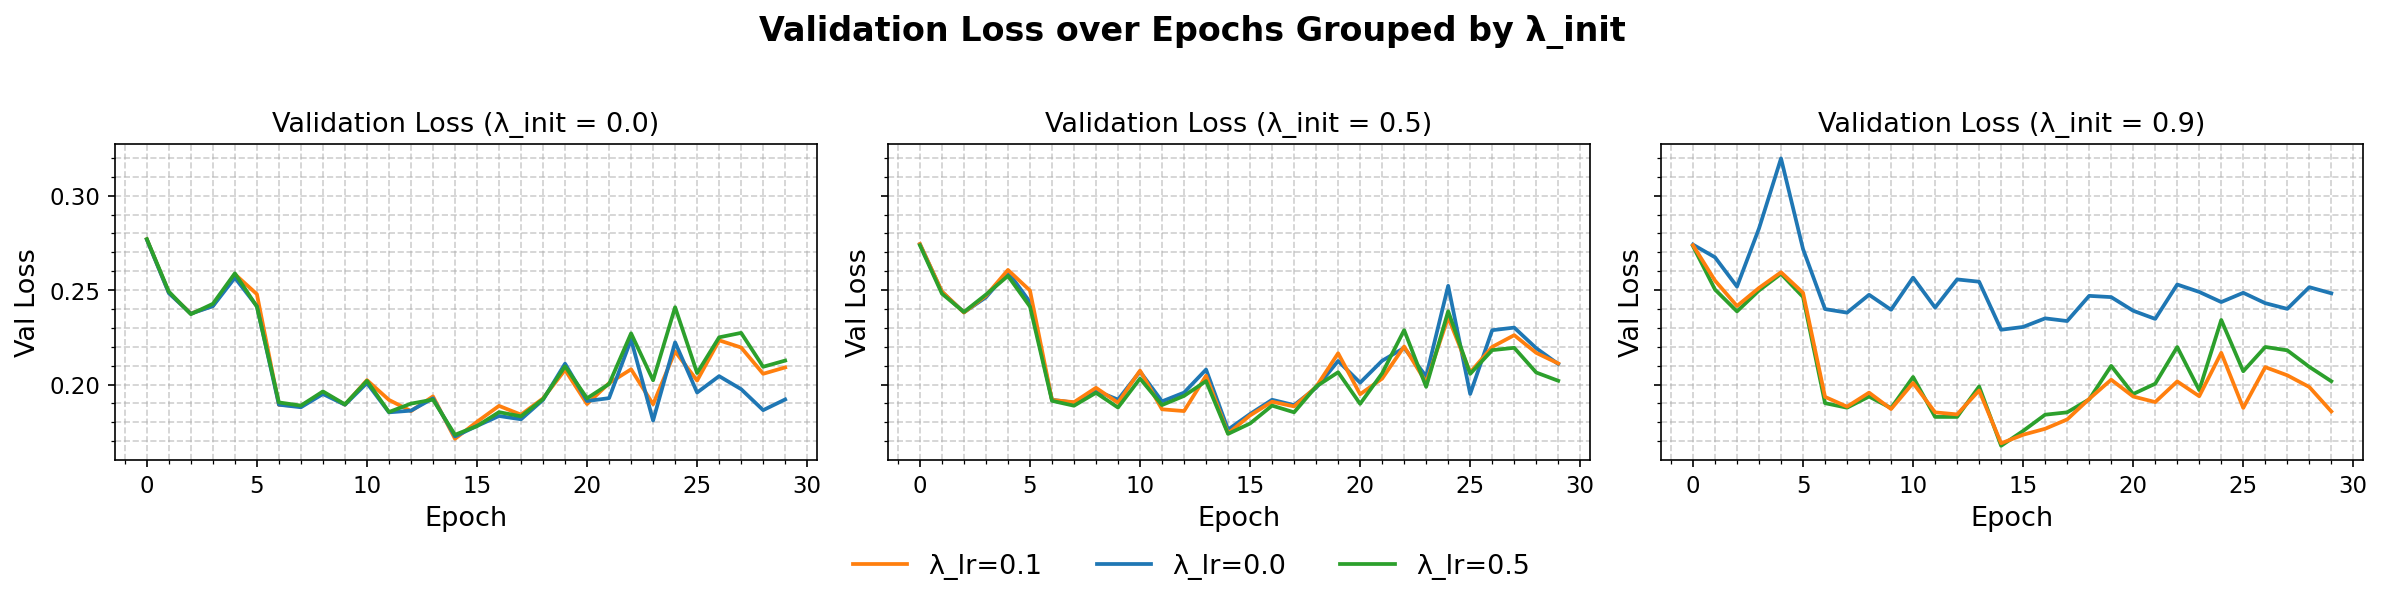

In [ ]:
runs_path = Path("../runs/exper2/classification/churn/adapt_ncl_sweep")
all_histories = load_histories(Path("../runs/exper2/classification/churn/adapt_ncl_sweep"))

plot_global(all_histories)

## **Multi-λ**

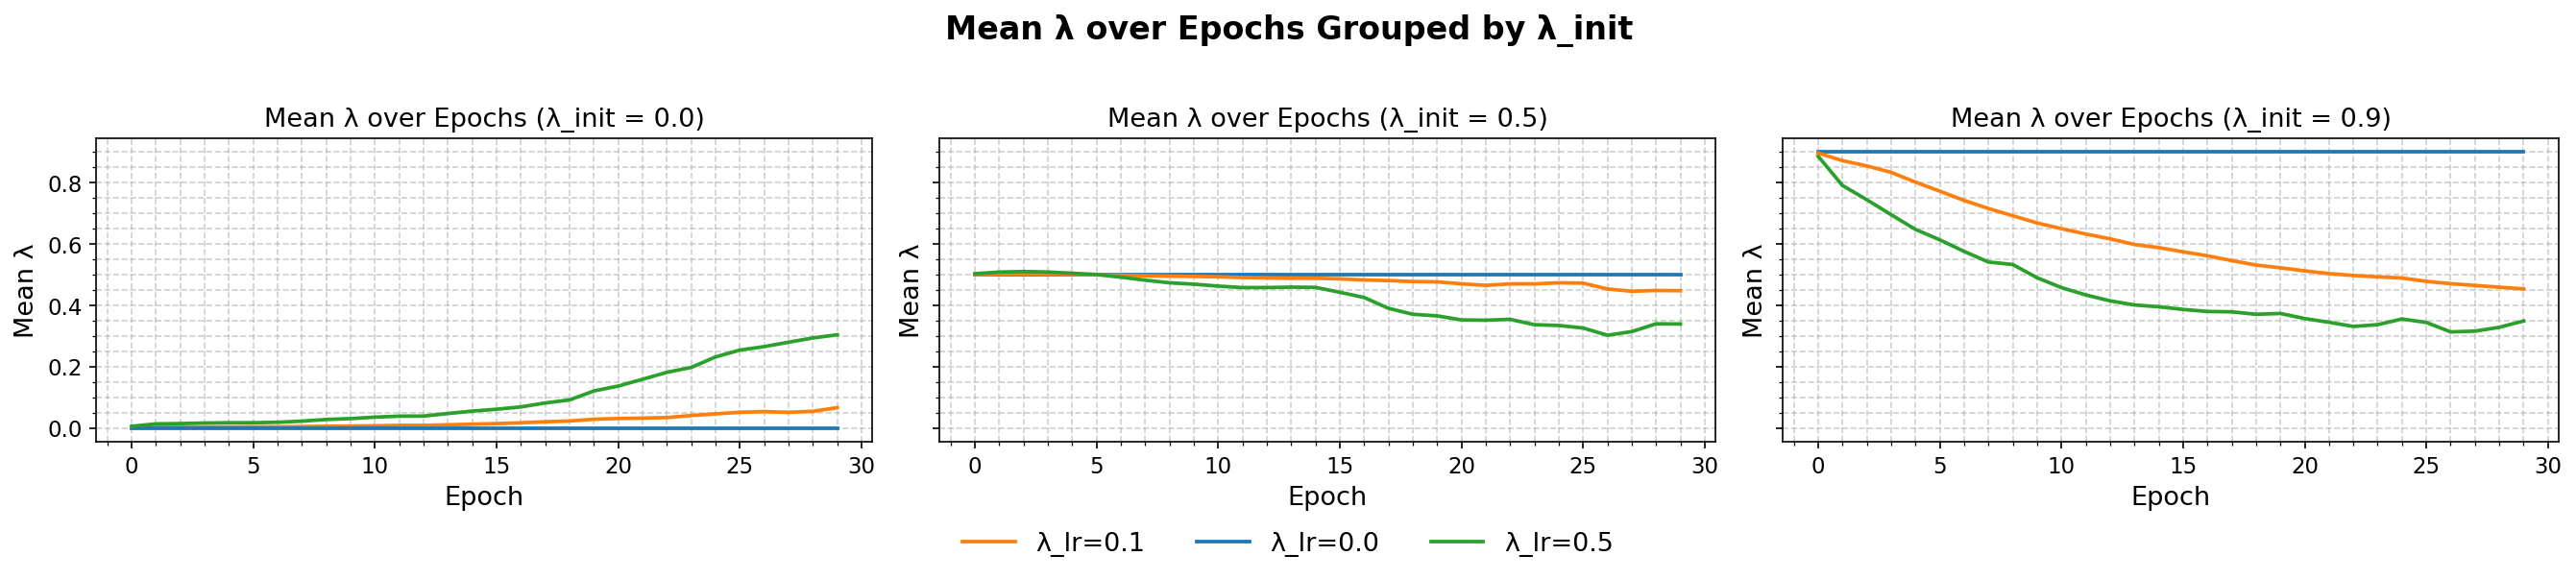

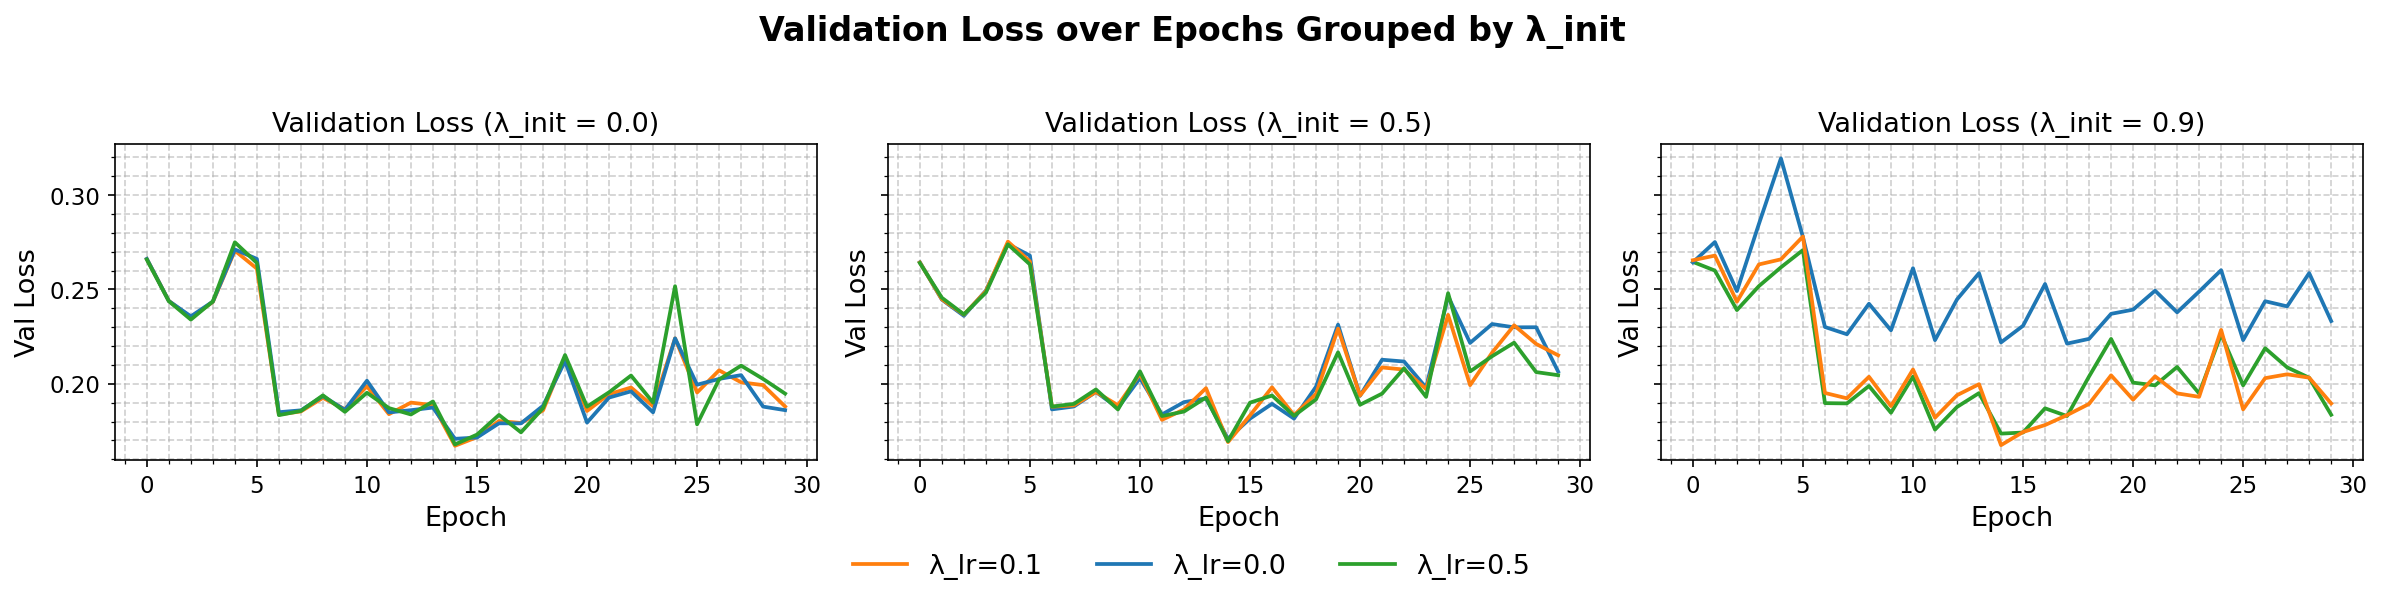

In [3]:
runs_path = Path("../runs/exper2/classification/churn/multi_adapt_ncl_sweep")
all_histories = load_histories(runs_path)

plot_multi(all_histories)

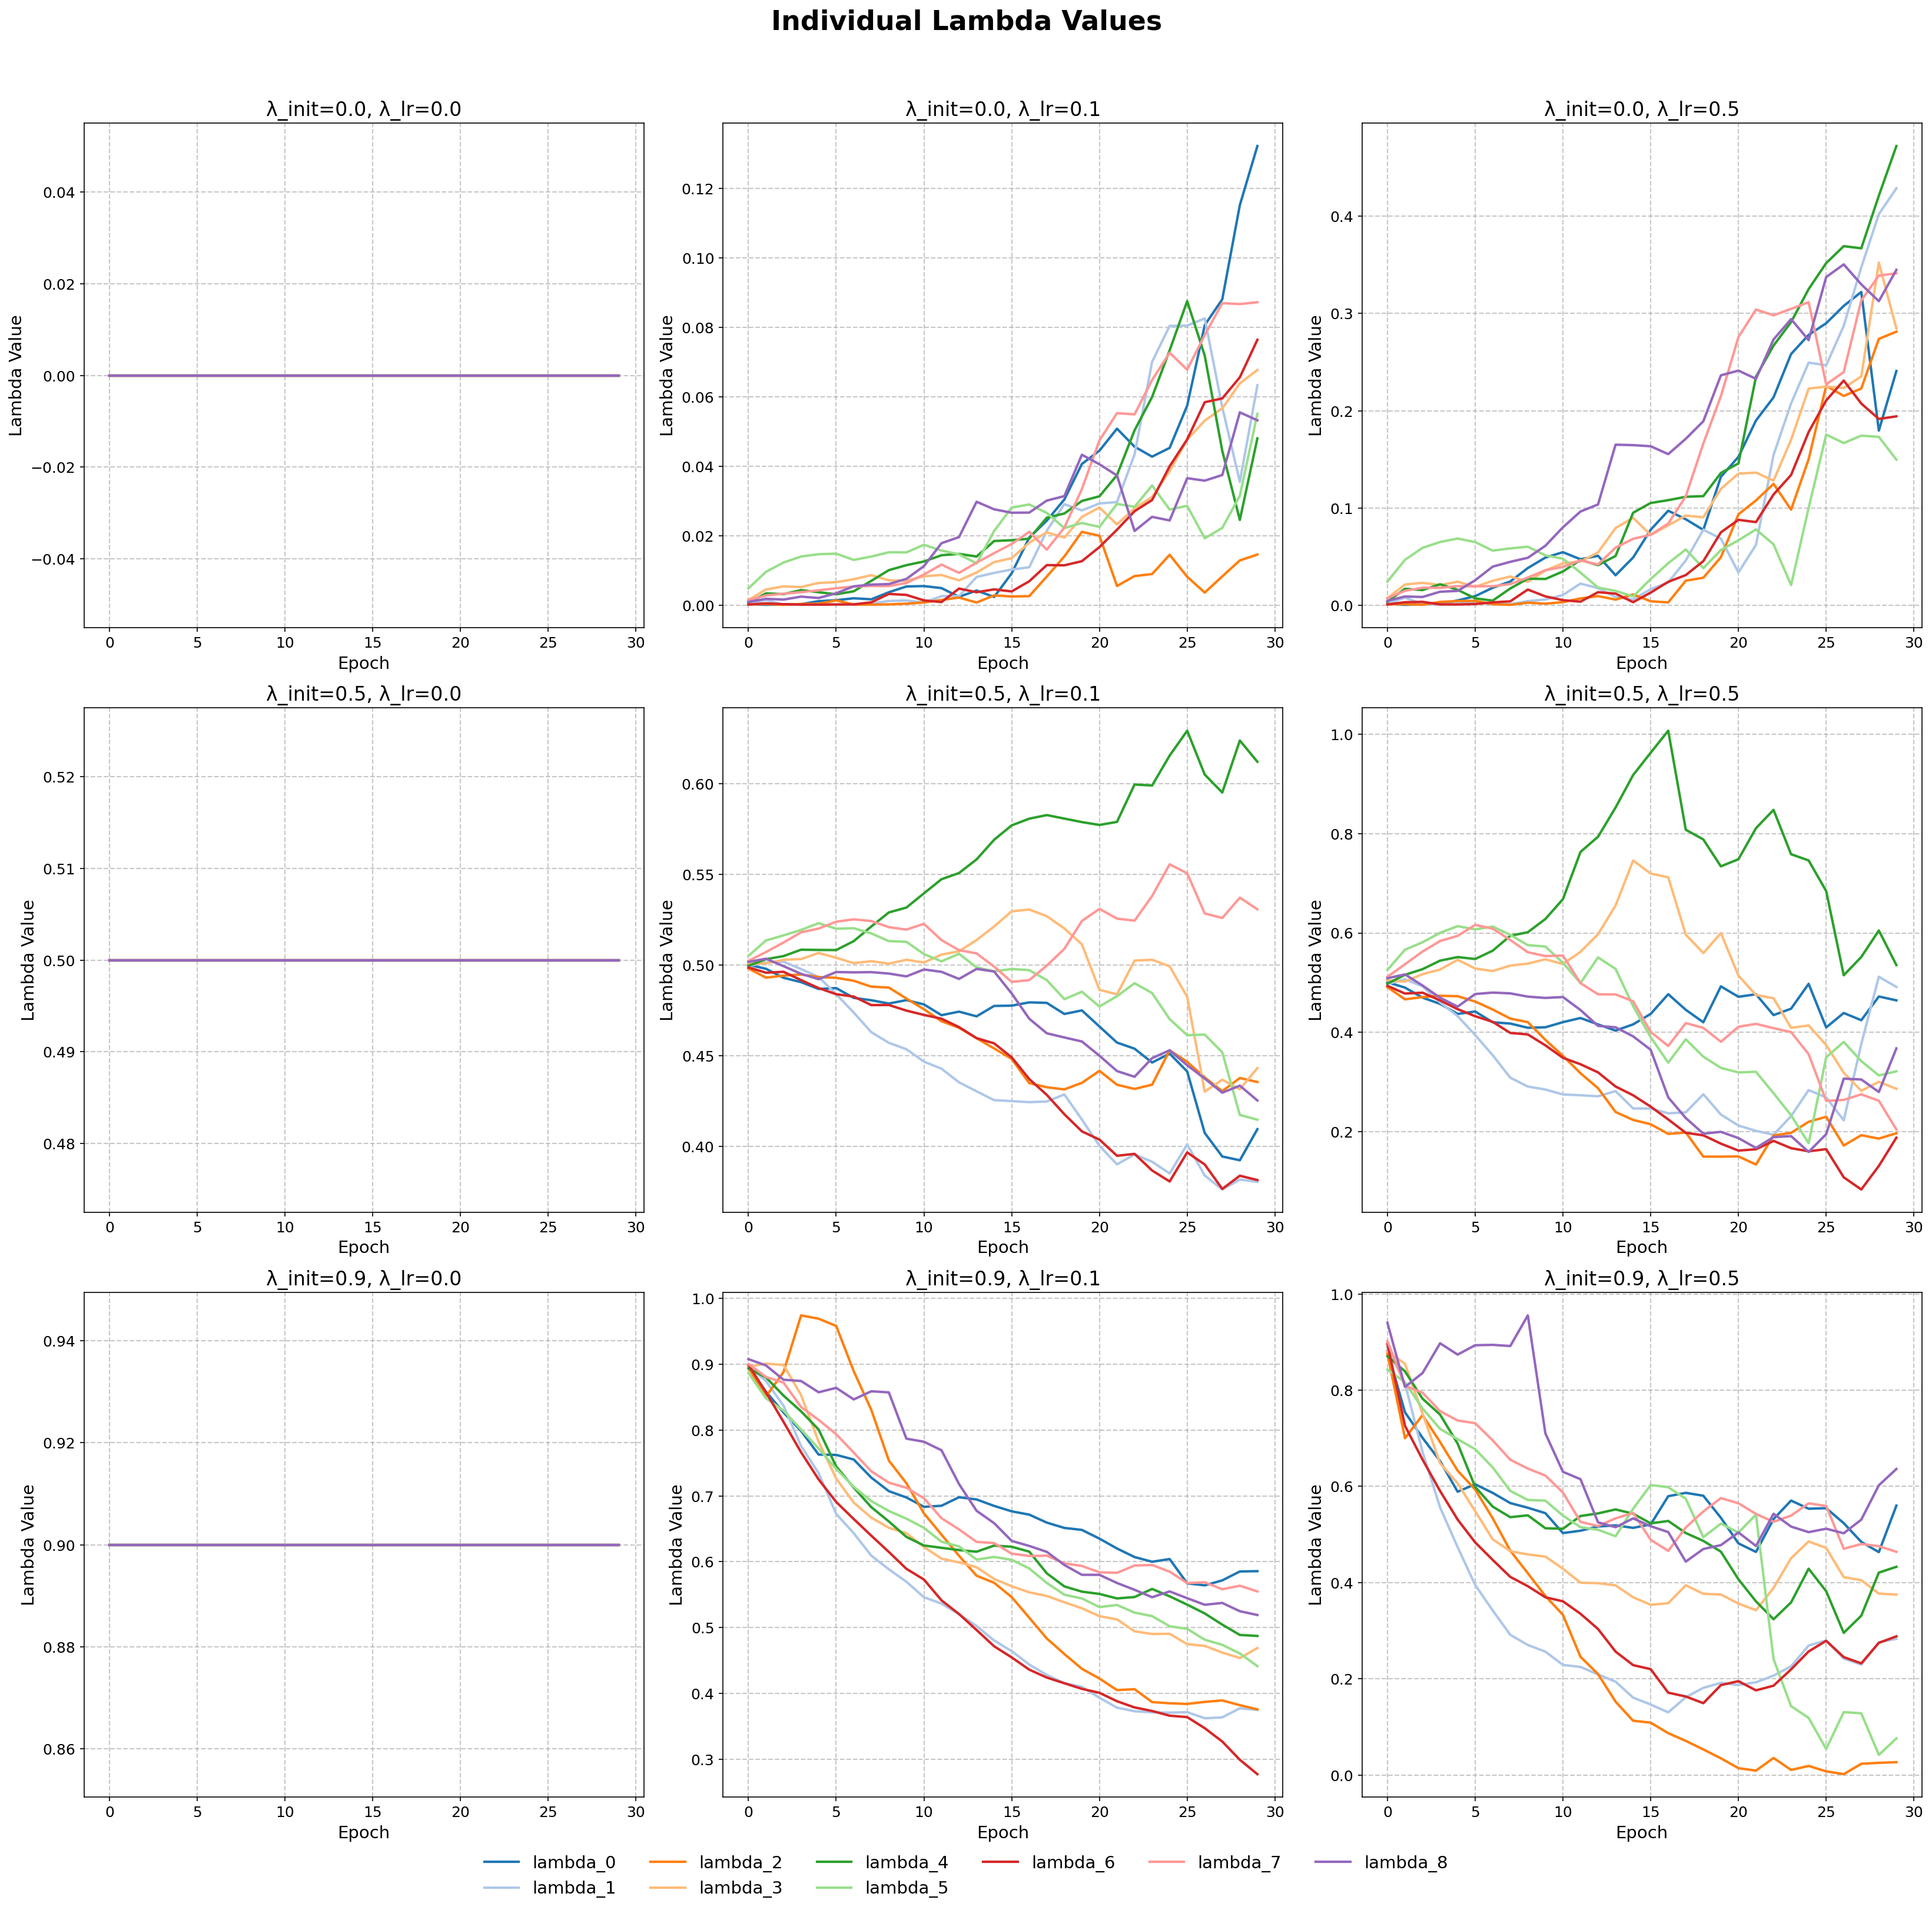

In [10]:
plot_individual_lambdas(all_histories)

# **Waveform**

## **Global-λ**

[0.0, 0.5, 0.9]


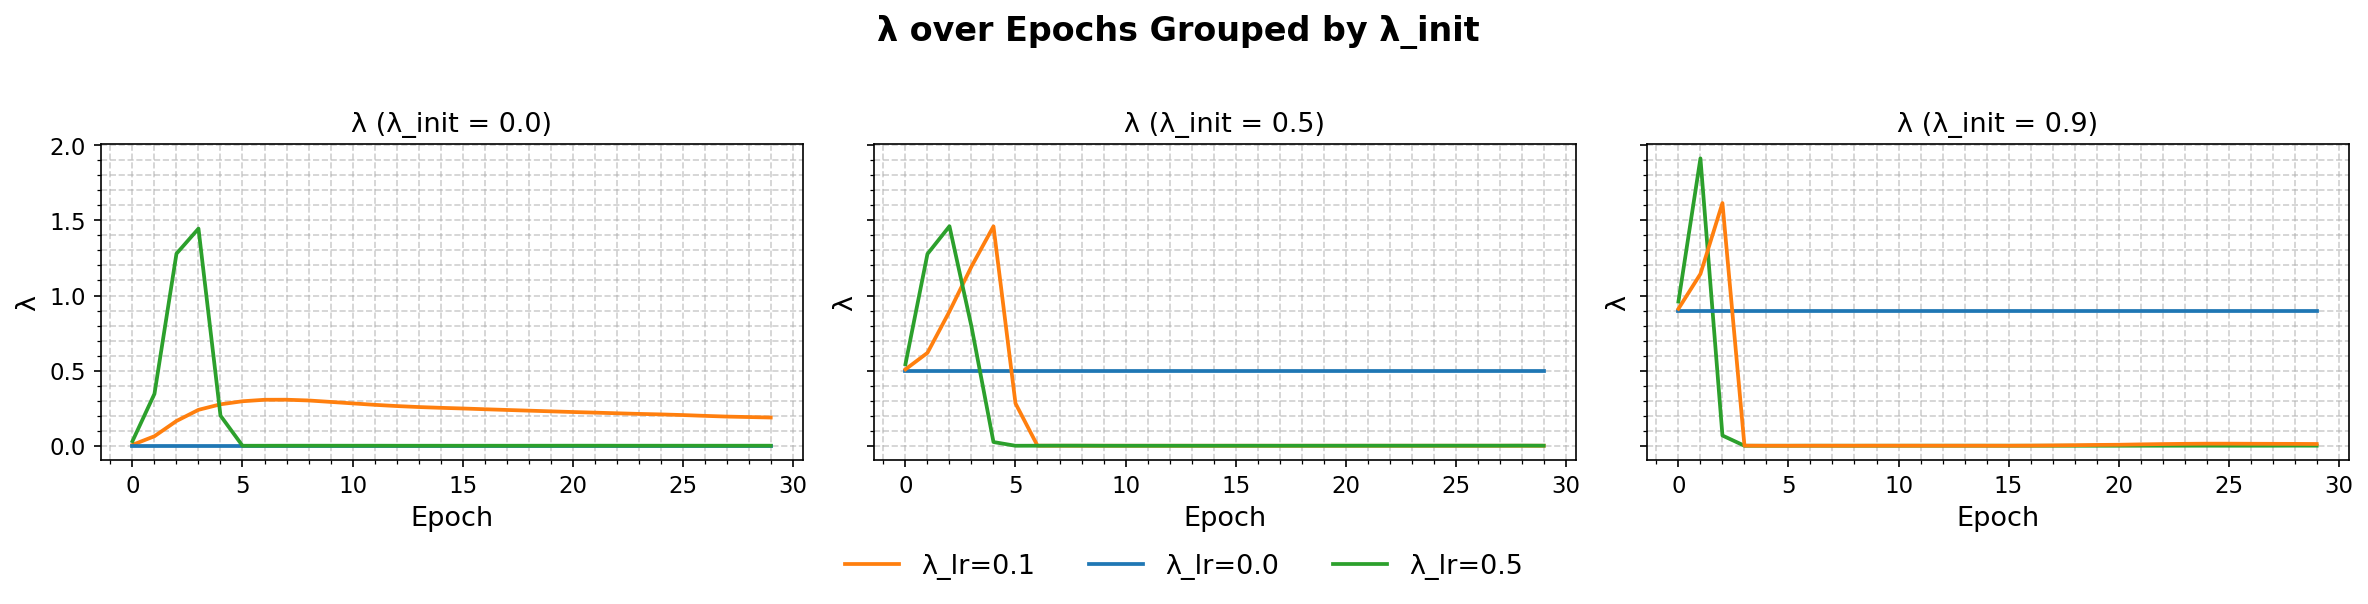

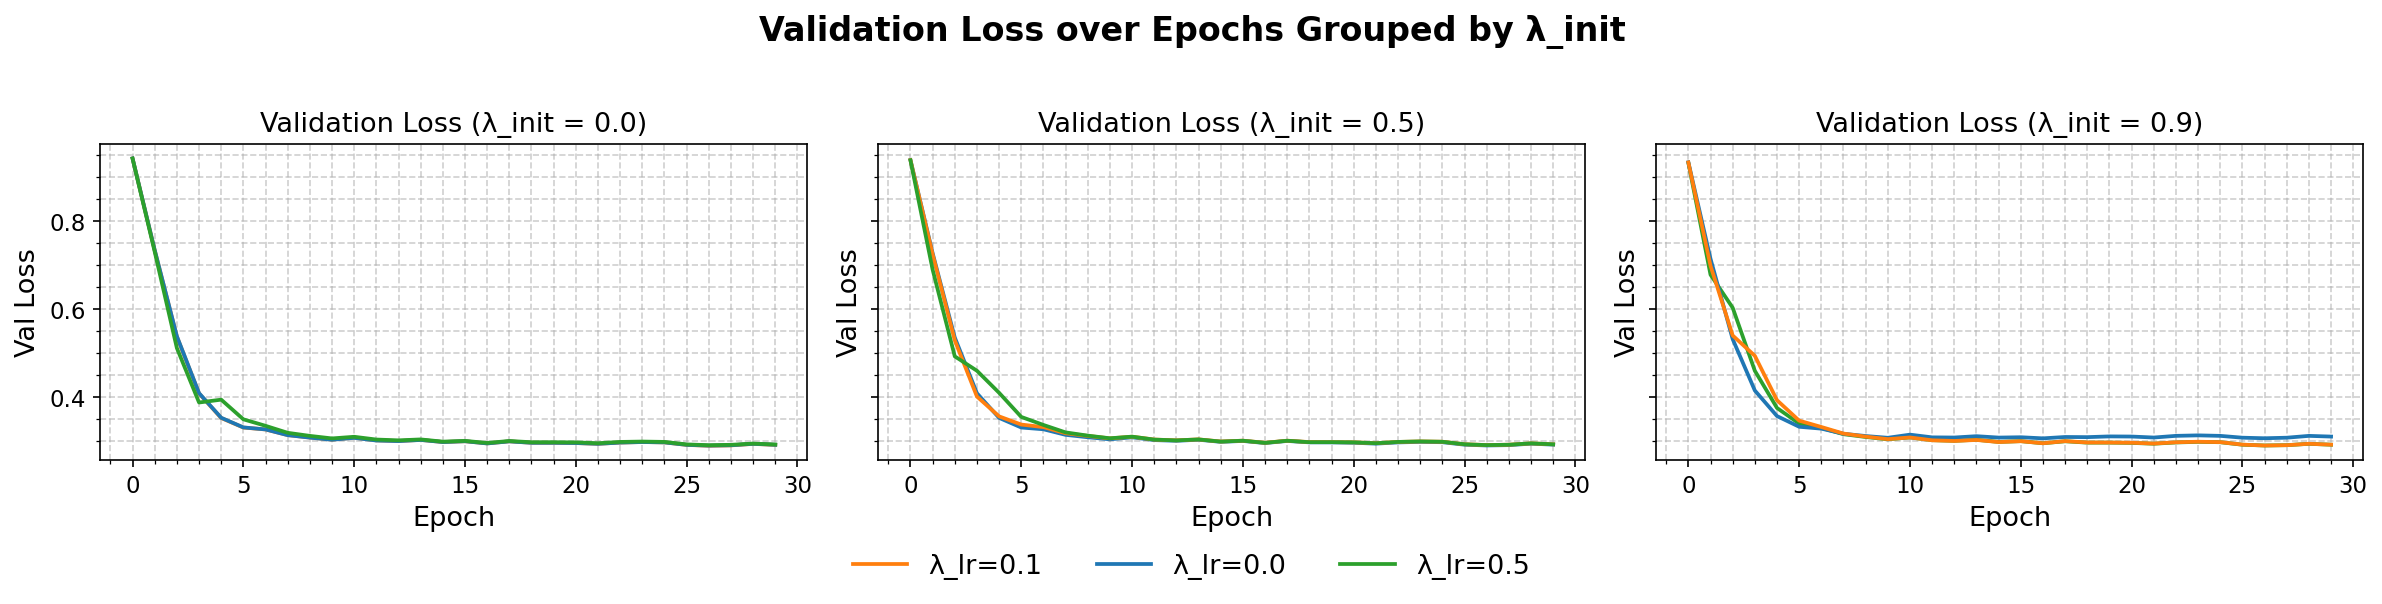

In [24]:
runs_path = Path("../runs/exper2/classification/waveform_21/adapt_ncl_sweep")
all_histories = load_histories(runs_path)

plot_global(all_histories)

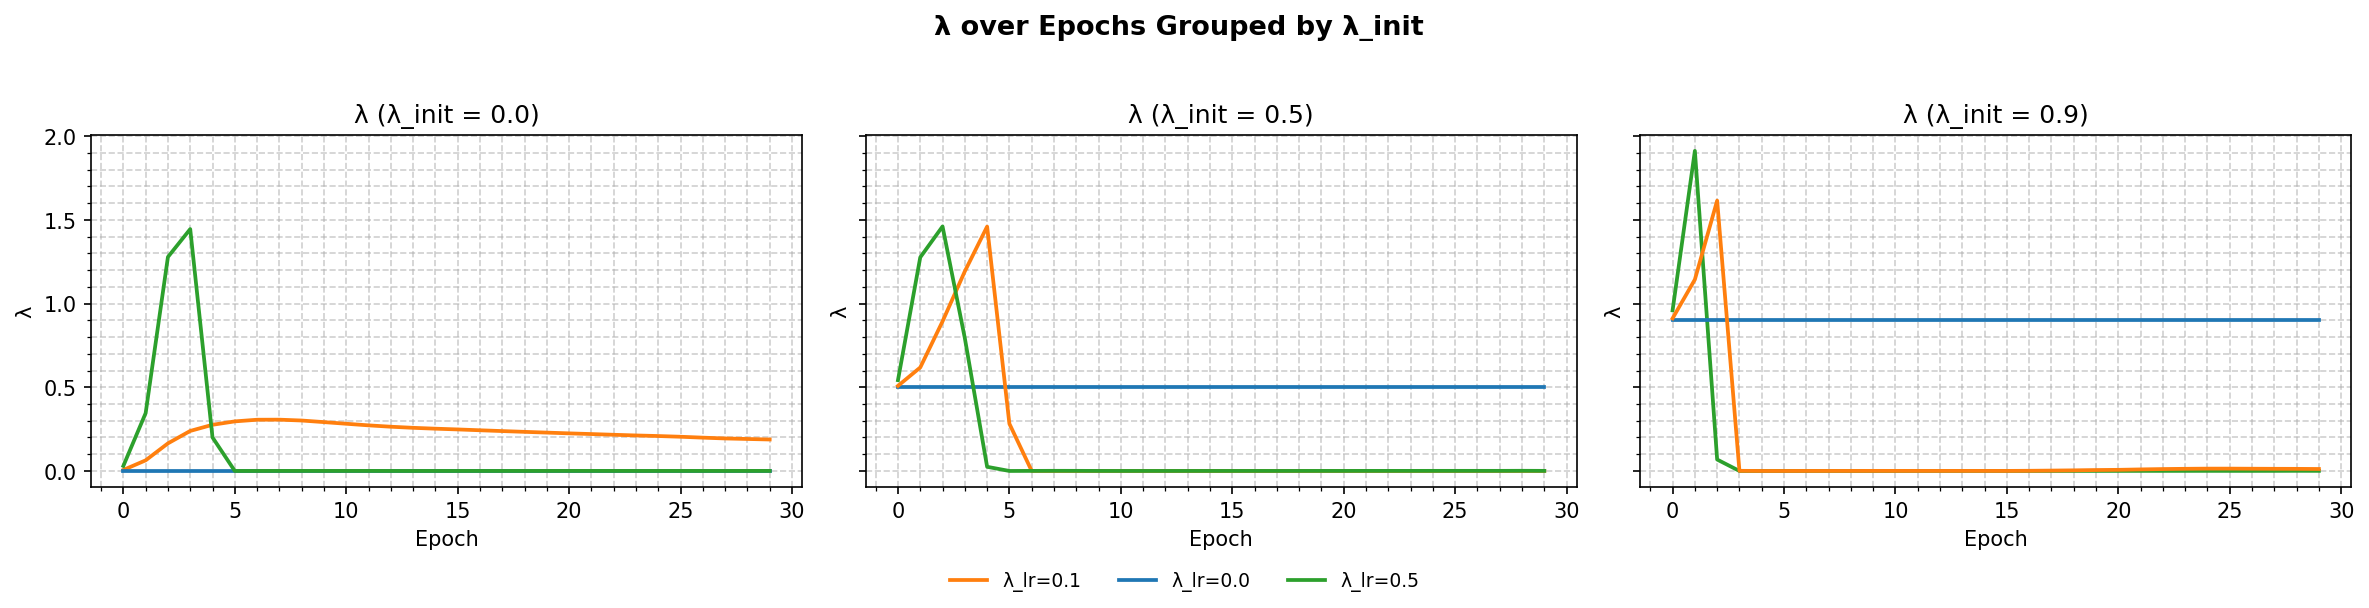

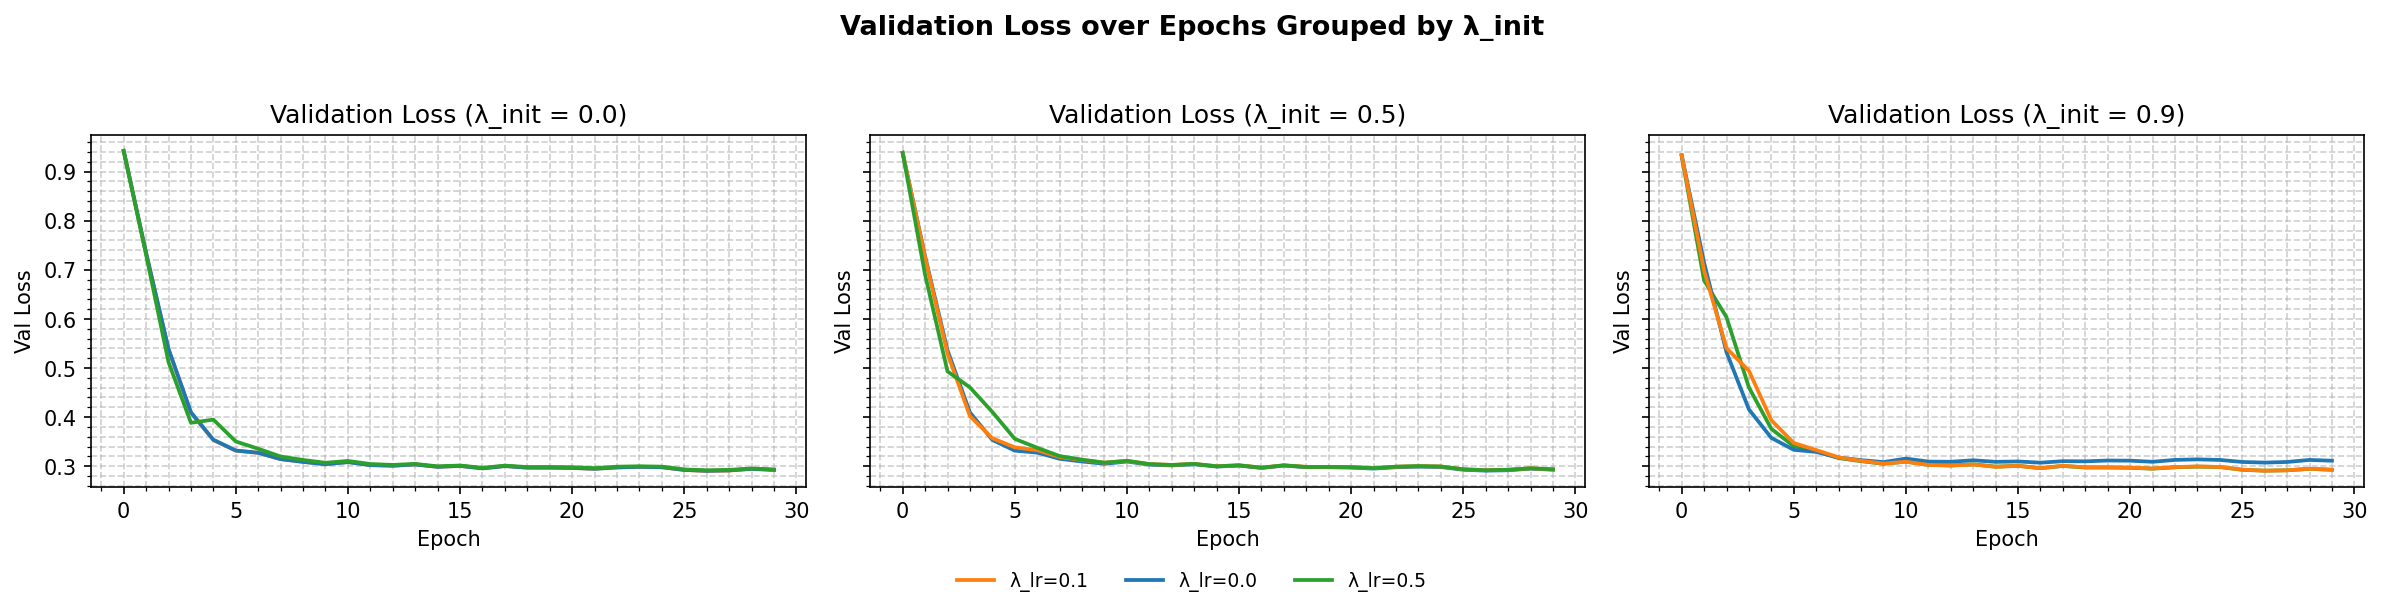

In [ ]:
runs_path = Path("../runs/exper2/classification/waveform_21/adapt_ncl_sweep")
all_histories = load_histories(runs_path)

def extract_param(run_name: str, key: str) -> float:
    """
    Extract numeric sweep parameters such as lambda_init and lambda_lr
    from names like: 'sweep_lambda_init=1.05__lambda_lr=0.1'
    """
    m = re.search(rf"{key}=([0-9.]+)", run_name)
    if not m:
        raise ValueError(f"Could not find {key} in run name: {run_name}")
    return float(m.group(1))

# --- group runs by lambda_init and collect learning rates ---
groups = defaultdict(list)
lr_values = set()

for run_name, history in all_histories.items():
    lam_init = extract_param(run_name, "lambda_init")
    lam_lr   = extract_param(run_name, "lambda_lr")
    lr_values.add(lam_lr)
    groups[lam_init].append((run_name, lam_lr, history))

lambda_inits = sorted(groups.keys())
lr_values = sorted(lr_values)

# --- consistent colors per learning rate ---
cmap = plt.get_cmap("tab10")
lr_to_color = {lr: cmap(i % 10) for i, lr in enumerate(lr_values)}


# ------------------------------------------------------------------
# 1) λ over epochs (as before, but kept here for completeness)
# ------------------------------------------------------------------
fig, axs = plt.subplots(1, len(lambda_inits), figsize=(16, 4), dpi=150, sharey=True)
if len(lambda_inits) == 1:
    axs = [axs]

fig.suptitle("λ over Epochs Grouped by λ_init", fontsize=13, weight="bold")

for ax, lam_init in zip(axs, lambda_inits):
    for run_name, lam_lr, history in groups[lam_init]:
        epochs = range(len(history["lambda"]))
        color = lr_to_color[lam_lr]
        label = f"λ_lr={lam_lr}"

        ax.plot(epochs, history["lambda"], lw=1.8, label=label, color=color)

    ax.set_title(f"λ (λ_init = {lam_init})")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("λ")
    ax.grid(True, which="both", linestyle="--", alpha=0.6)
    ax.minorticks_on()

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=len(labels), fontsize=9, frameon=False)
fig.tight_layout(rect=[0, 0.05, 1, 0.95])  # extra bottom space for legend
plt.show()



# ------------------------------------------------------------------
# 3) Validation loss over epochs (what you just posted, completed)
# ------------------------------------------------------------------
fig, axs = plt.subplots(1, len(lambda_inits), figsize=(16, 4), dpi=150, sharey=True)
if len(lambda_inits) == 1:
    axs = [axs]

fig.suptitle("Validation Loss over Epochs Grouped by λ_init", fontsize=13, weight="bold")

for ax, lam_init in zip(axs, lambda_inits):
    for run_name, lam_lr, history in groups[lam_init]:
        if "val_loss" not in history:
            continue

        epochs = range(len(history["val_loss"]))
        color = lr_to_color[lam_lr]
        label = f"λ_lr={lam_lr}"

        ax.plot(epochs, history["val_loss"], lw=1.8, label=label, color=color)

    ax.set_title(f"Validation Loss (λ_init = {lam_init})")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Val Loss")
    ax.grid(True, which="both", linestyle="--", alpha=0.6)
    ax.minorticks_on()

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=len(labels), fontsize=9, frameon=False)
fig.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


## **Multi-λ**

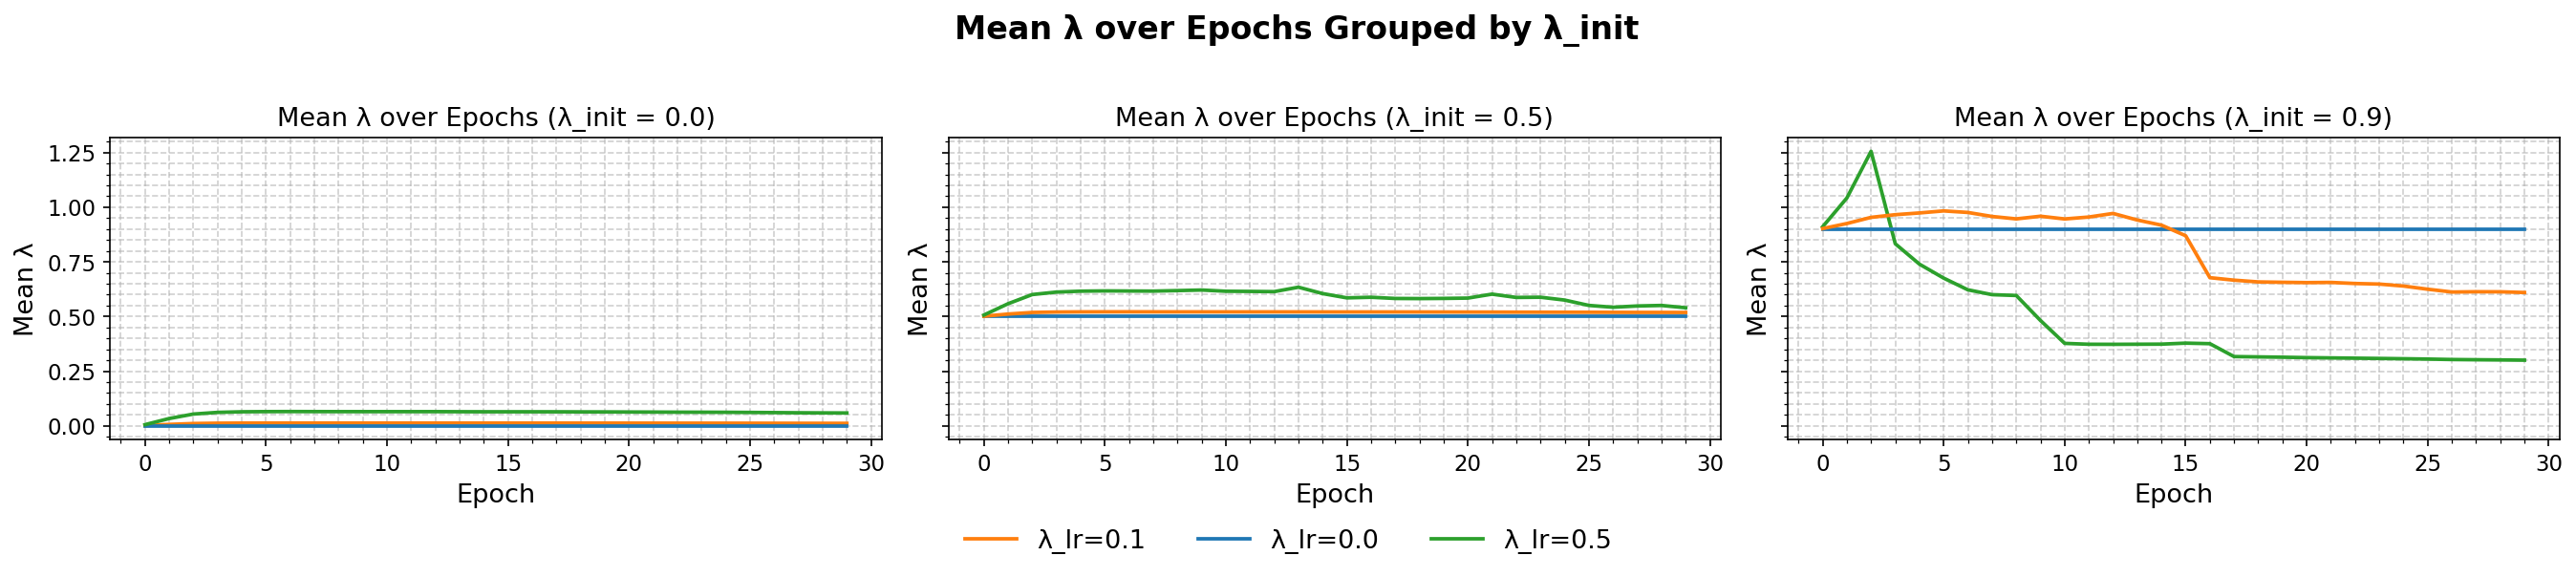

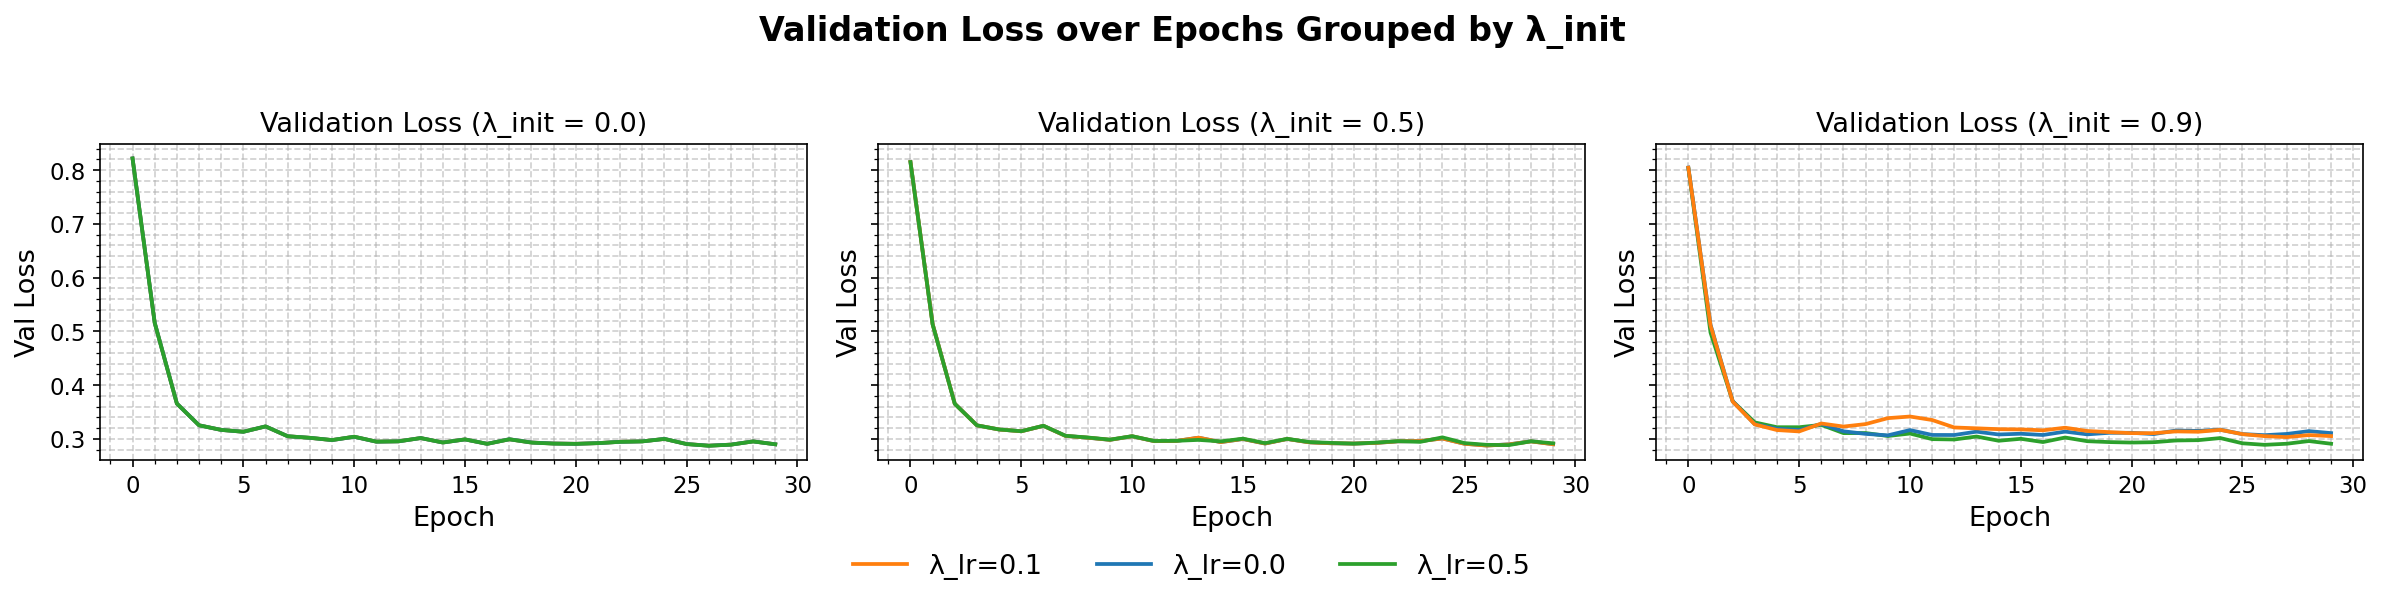

In [11]:
runs_path = Path("../runs/exper2/classification/waveform_21/multi_adapt_ncl_sweep")
all_histories = load_histories(runs_path)

plot_multi(all_histories)

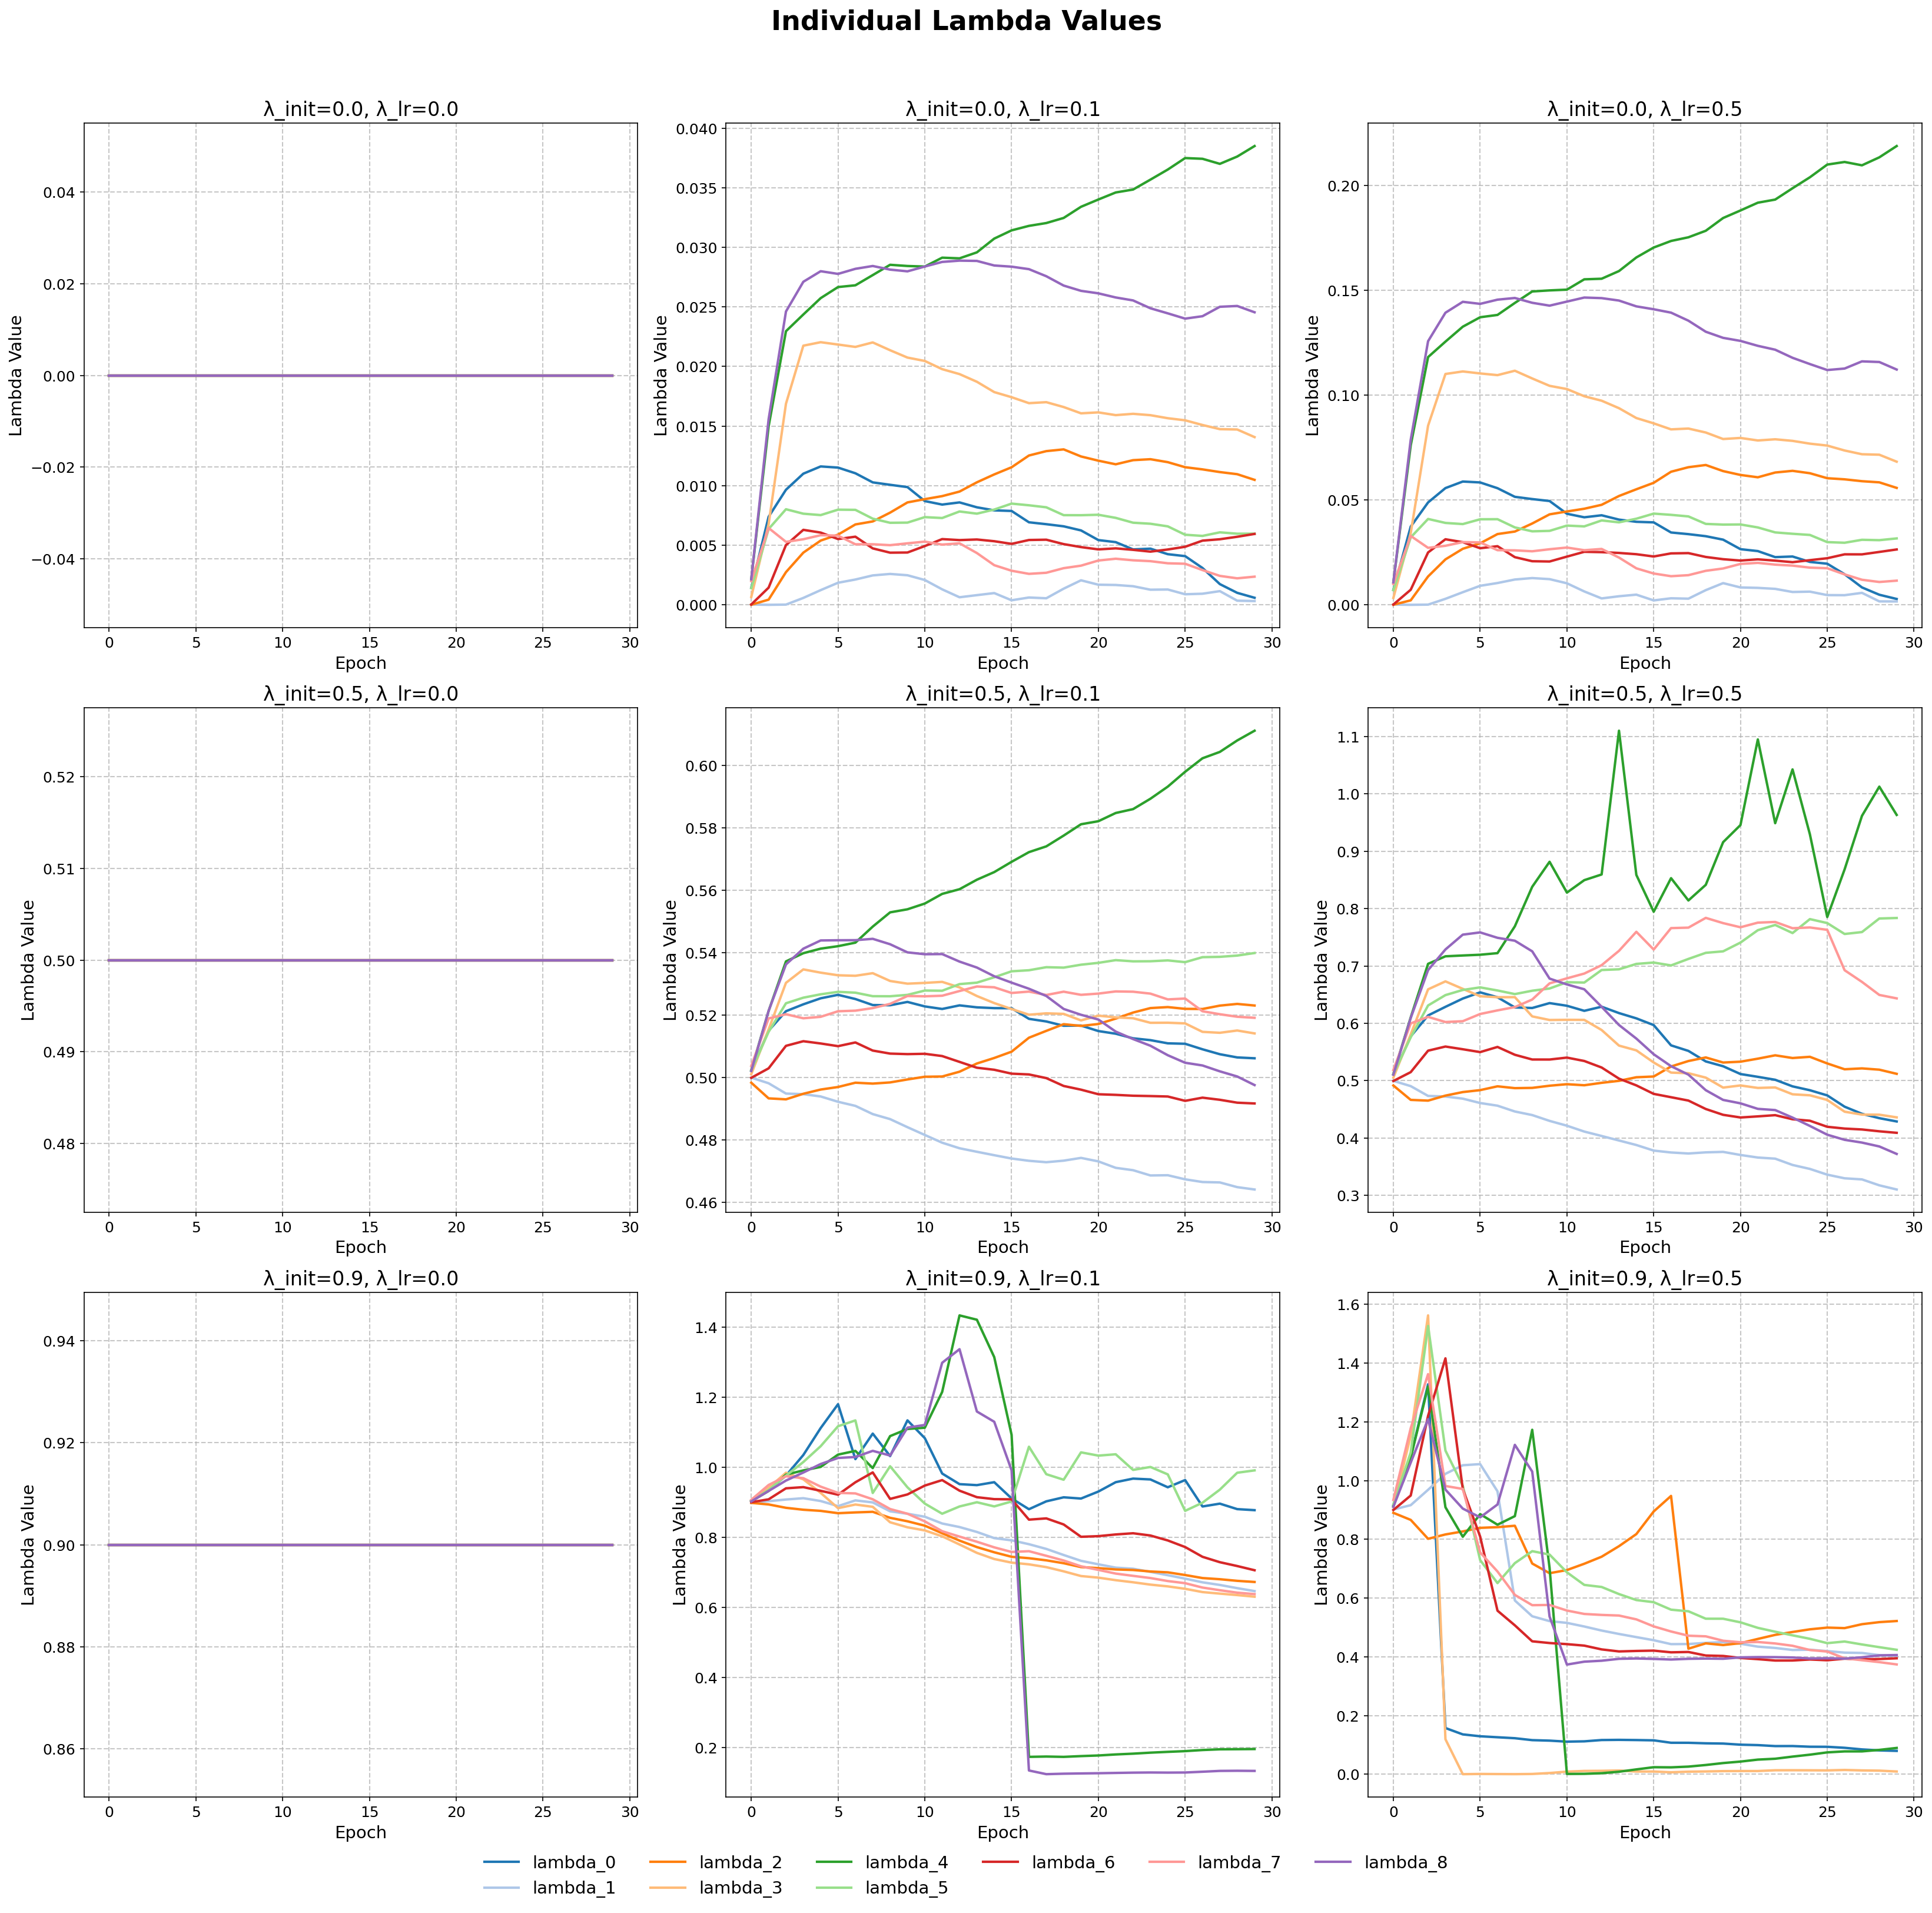

In [12]:
plot_individual_lambdas(all_histories)

# **Pollen**

## **Global-λ**

[0.0, 0.5, 0.9]


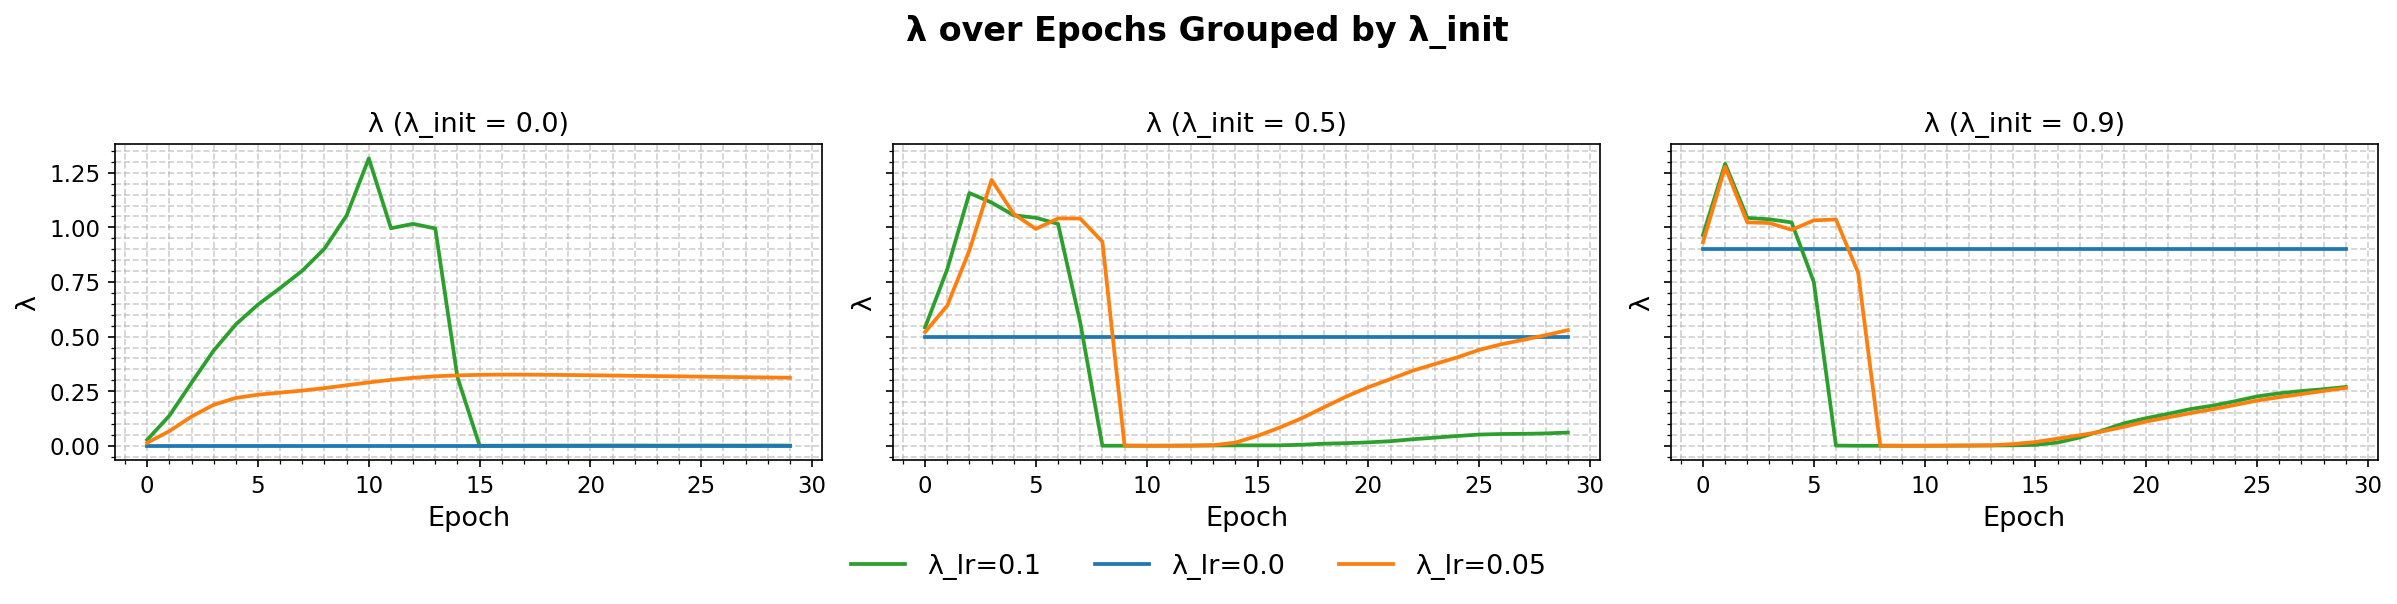

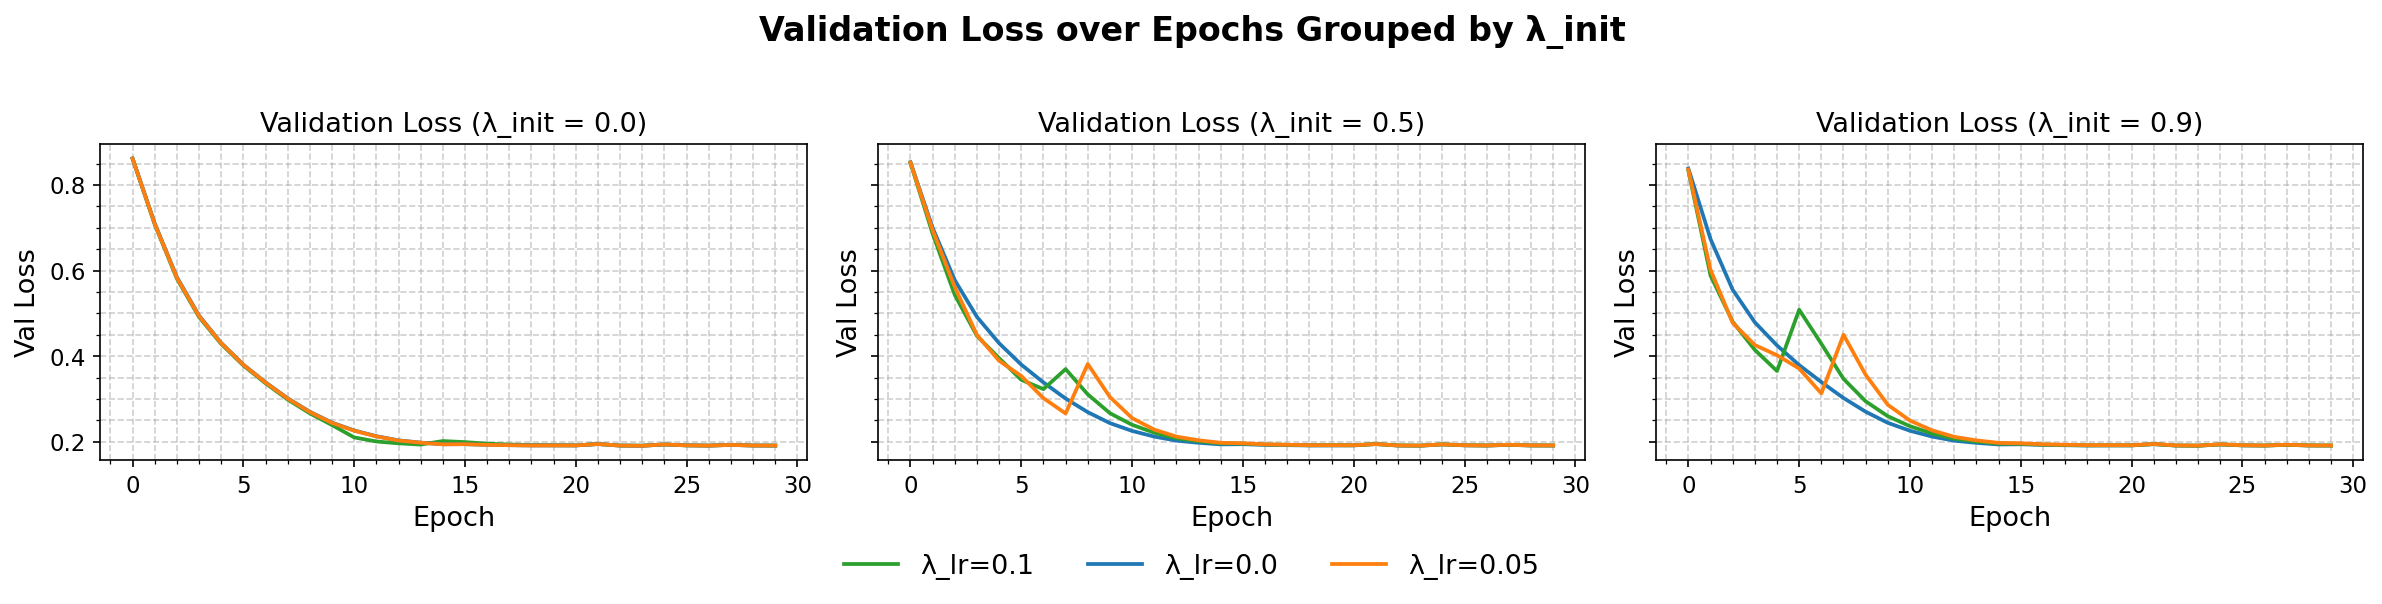

In [13]:
runs_path = Path("../runs/exper2/regression/529_pollen/adapt_ncl_sweep")
all_histories = load_histories(runs_path)

plot_global(all_histories)

## **Multi-λ**

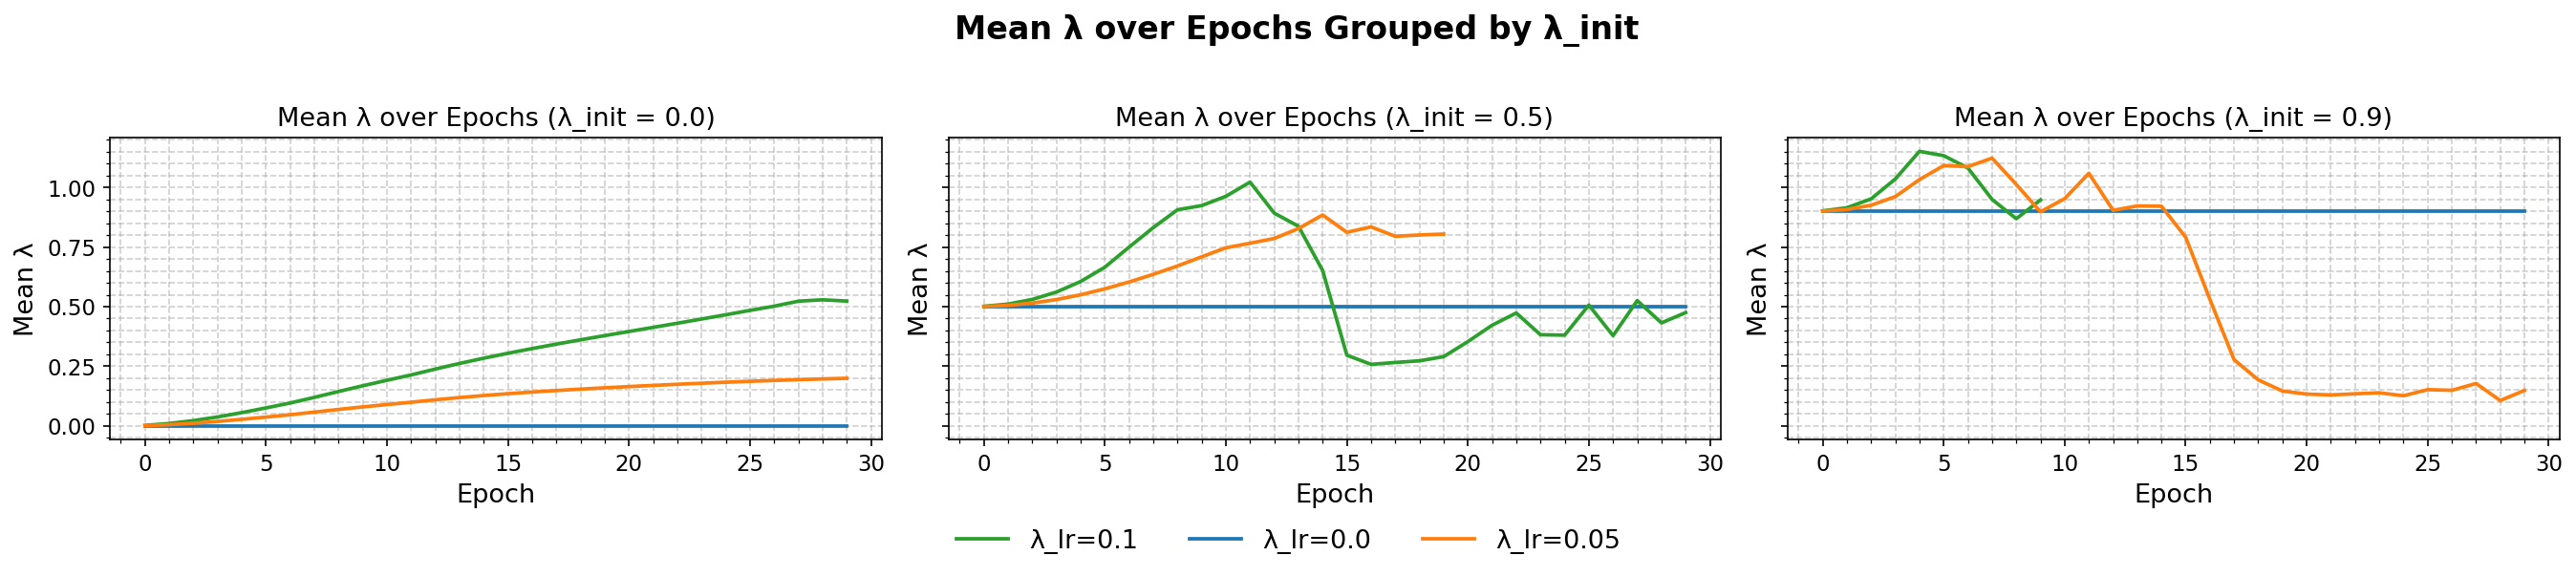

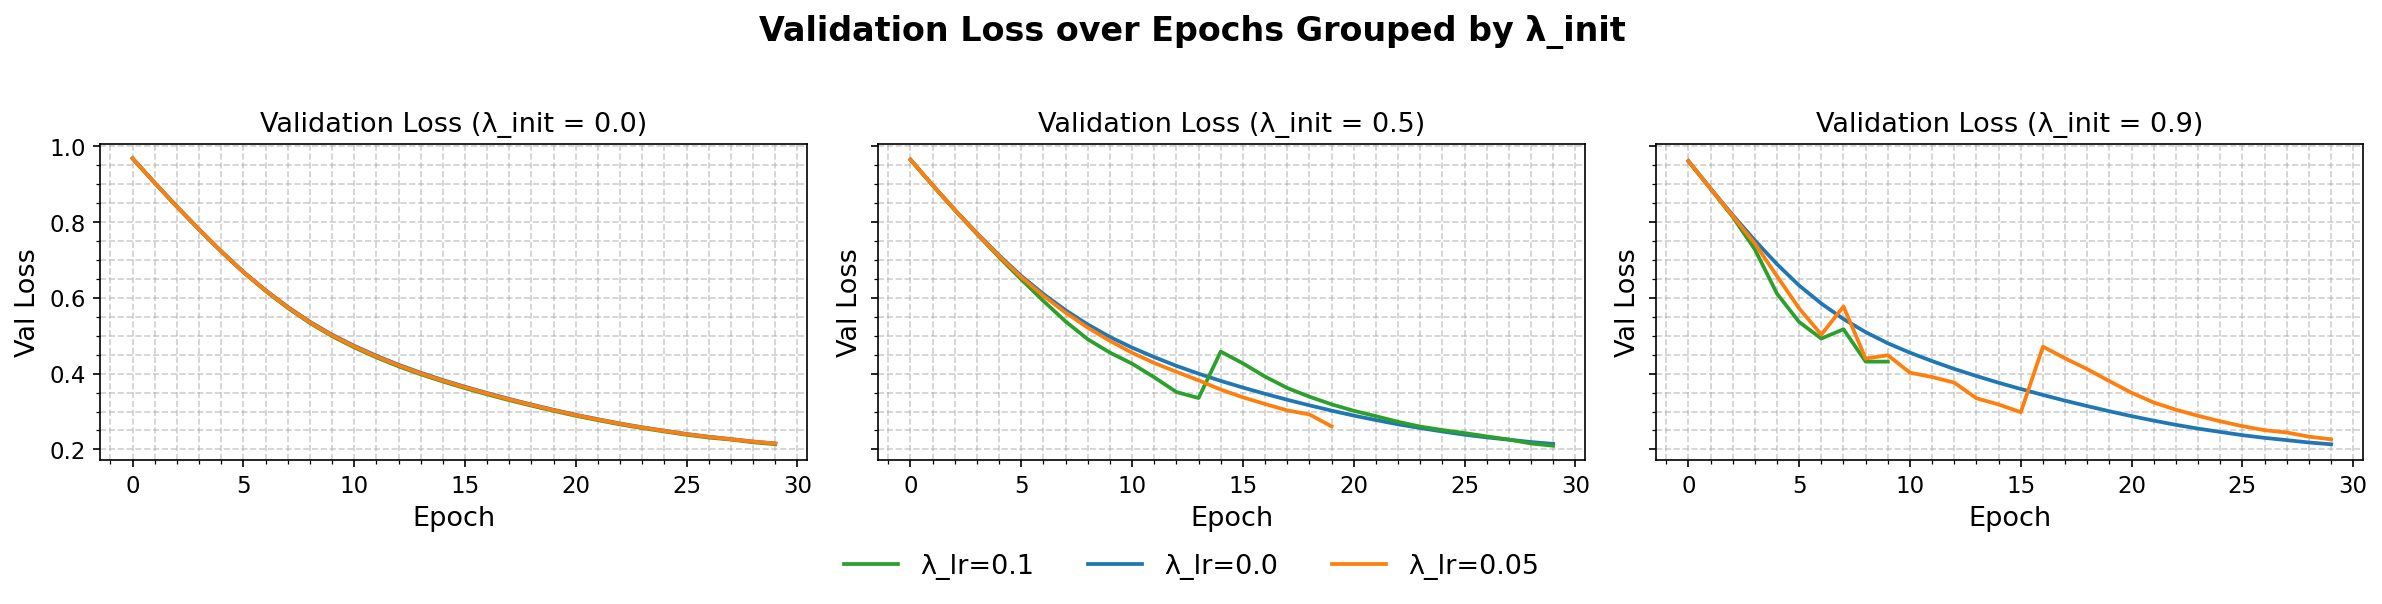

In [14]:
runs_path = Path("../runs/exper2/regression/529_pollen/multi_adapt_ncl_sweep")
all_histories = load_histories(runs_path)

plot_multi(all_histories)

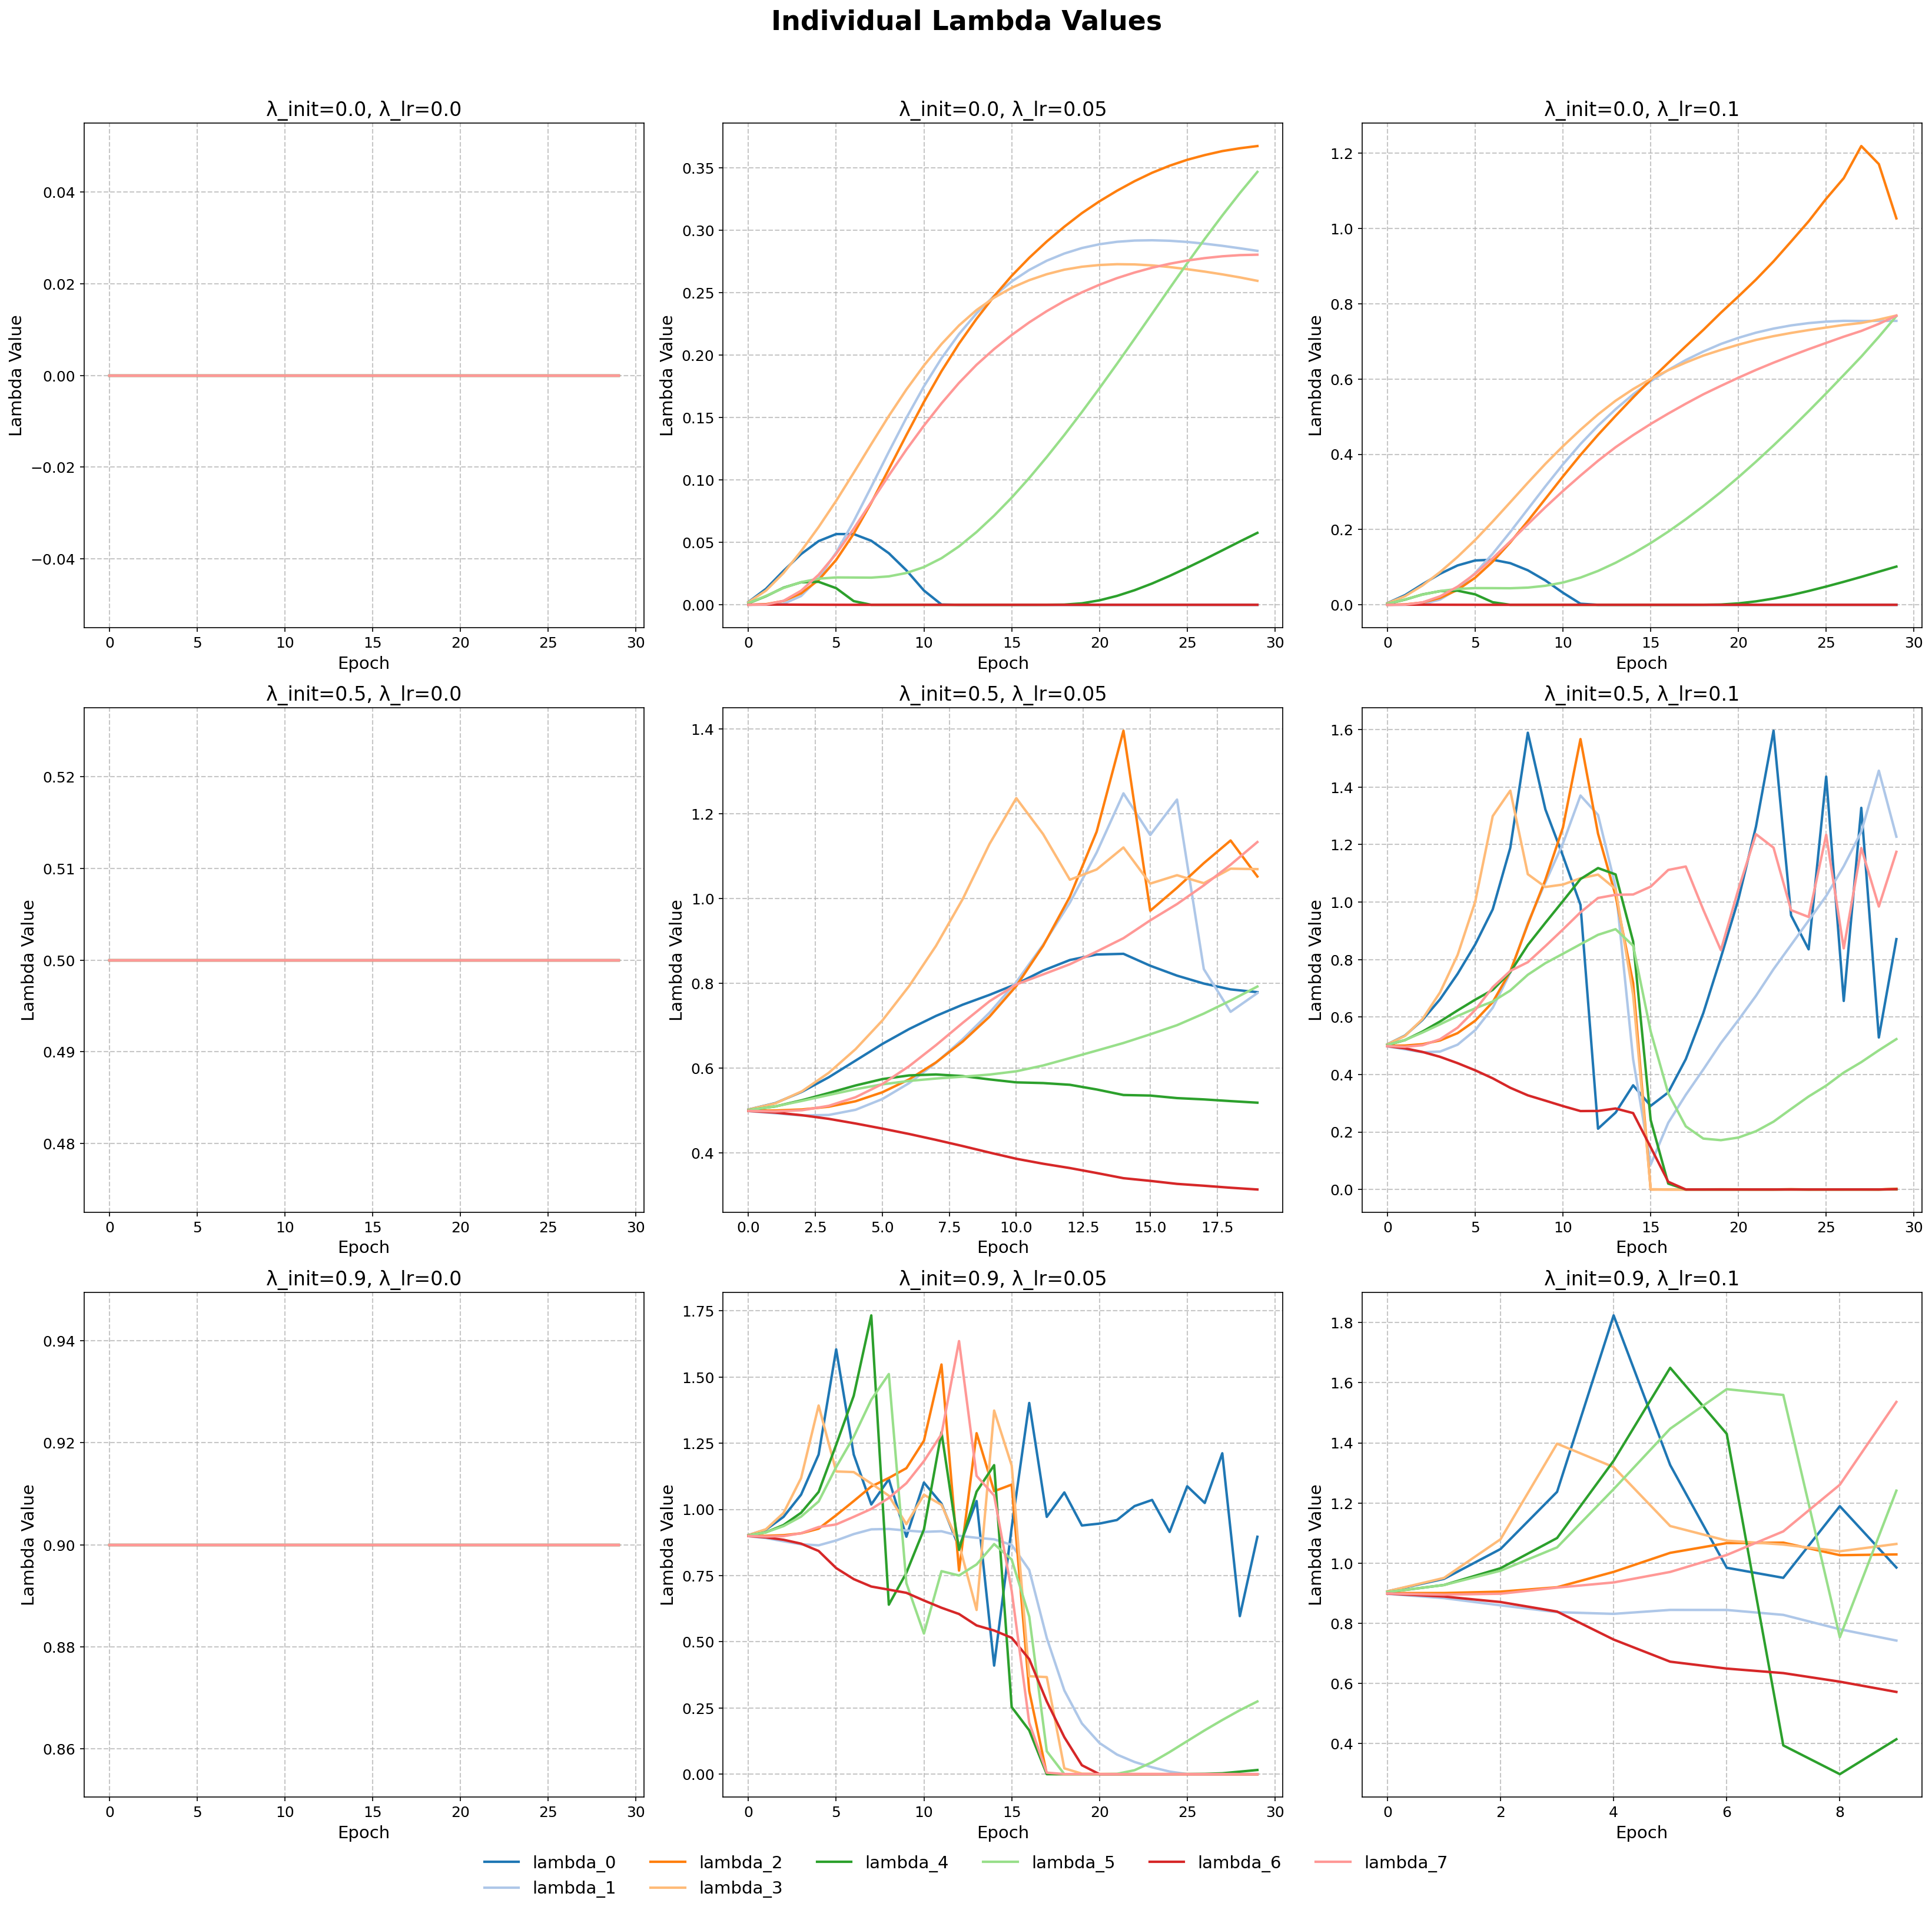

In [15]:
plot_individual_lambdas(all_histories)